In [1]:
import numpy as np
import pickle
import os
import pyimfit
from astropy.io import fits
from astropy.wcs import WCS
from astropy.coordinates import angular_separation
import corner
import matplotlib.pyplot as plt
import pandas as pd
from photutils import profiles
from tqdm import tqdm
import logging
import warnings
from matplotlib.backends.backend_pdf import PdfPages
from astropy.visualization import simple_norm
warnings.filterwarnings('ignore')
from photutils.aperture import EllipticalAperture
from photutils.isophote import build_ellipse_model,Ellipse, EllipseGeometry, IsophoteList
from matplotlib.ticker import FormatStrFormatter

medium_font_size = 14 
plt.rcParams['font.size'] = medium_font_size
plt.rcParams['axes.labelsize'] = medium_font_size
plt.rcParams['axes.titlesize'] = medium_font_size
plt.rcParams['xtick.labelsize'] = medium_font_size
plt.rcParams['ytick.labelsize'] = medium_font_size

fl = os.listdir("../cutouts/data")
agns = sorted([f[:-5] for f in fl if f[0]=="J"])

# make galaxy models
I_tot is the integrated intensity. Feeding position at 50,70 gives model image at 49,69

In [2]:
def find_highest_indices(arr):
    """returns a tuple of ys, xs - indices of pixels with highest counts"""
    flattened_arr = np.array(arr).flatten()
    max_indices = np.unravel_index(np.argsort(flattened_arr)[-2:], arr.shape)
    return max_indices


def crop_image(imageAGN, size=40):
    ysO,xsO = find_highest_indices(imageAGN)
    # find the center of AGNs
    ycO = int(np.sum(ysO)/2)
    xcO = int(np.sum(xsO)/2)
    # crop
    px=int(size/2)
    imageAGNcrop = imageAGN[ycO-px:ycO+px,xcO-px:xcO+px]
    # find agn centers in cropped image
    ys,xs = find_highest_indices(imageAGNcrop)
    return imageAGNcrop, ys, xs

    


def makeModelDict(PA_ss, ell_ss, n_ss, I_ss, r_ss, Itot,
                 PA_lim, ell_lim, I_lim,  Iss_lim, rss_lim, Itot_lim,
                 sigma, sigma_lim, Isky, Isky_lim,
                 h1,h2,h_lim,alpha,alpha_lim):
    """Return Sersic, PSF, and Gaussian model parameter dictionary"""
    # Sersic
    """sersic = {'PA': [PA_ss, PA_lim[0],PA_lim[1]], 'ell_bulge': [ell_ss, ell_lim[0],ell_lim[1]], 'n': [n_ss, 'fixed'],
    'I_e': [I_ss, Iss_lim[0],Iss_lim[1]], 'r_e': [r_ss, rss_lim[0],rss_lim[1]]}"""
    sersic = {'PA': [PA_ss, PA_lim[0],PA_lim[1]], 'ell_bulge': [ell_ss, ell_lim[0],ell_lim[1]], 'n': [n_ss, 0, 10],
    'I_e': [I_ss, Iss_lim[0],Iss_lim[1]], 'r_e': [r_ss, rss_lim[0],rss_lim[1]]}
    sersic_dict = {'name': "Sersic", 'label': "bulge", 'parameters': sersic}
    # PSF
    psf = {'I_tot' : [Itot, Itot_lim[0], Itot_lim[1]]}
    psf_dict = {'name': "PointSource", 'label': "psf", 'parameters': psf}
    # Rot psf
    psfRot = {'I_tot' : [Itot, Itot_lim[0], Itot_lim[1]], 'PA':[PA_ss, PA_lim[0],PA_lim[1]] }
    psfRot_dict = {'name': "PointSourceRot", 'label': "psf", 'parameters': psfRot}
    # Gaussians
    gaussian = {'PA':[PA_ss, PA_lim[0],PA_lim[1]], 'ell':[ell_ss, ell_lim[0],ell_lim[1]], 
                'I_0':[I_ss, Iss_lim[0],Iss_lim[1]], 'sigma':[sigma, sigma_lim[0], sigma_lim[1]]}
    gaussian_dict = {'name': "Gaussian", 'label': "gaussian", 'parameters': gaussian}
    # Flat sky
    flatsky = {'I_sky': [Isky, Isky_lim[0], Isky_lim[1]]}
    flatsky_dict = {'name': "FlatSky", 'label': "flat_sky", 'parameters':flatsky}
    # flat bar
    flatbar = {'PA':[PA_ss, PA_lim[0],PA_lim[1]], 'ell':[ell_ss, ell_lim[0],ell_lim[1]],
               'deltaPA_max':[PA_ss, PA_lim[0],PA_lim[1]], 'I_0':[I_ss, Iss_lim[0],Iss_lim[1]],
               'h1':[h1, h_lim[0],h_lim[1]], 'h2':[h2, h_lim[0],h_lim[1]], 
               'r_break':[r_ss, rss_lim[0],rss_lim[1]], 'alpha':[alpha,alpha_lim[0],alpha_lim[1]]}
    flatbar_dict = {'name': "FlatBar", 'label': "flat_bar", 'parameters':flatbar}
    # Exponential
    exponential = {'PA': [PA_ss, PA_lim[0],PA_lim[1]], 'ell': [ell_ss, ell_lim[0],ell_lim[1]], 
                   'I_0': [I_ss, Iss_lim[0],Iss_lim[1]], 'h': [h1, h_lim[0],h_lim[1]]}
    exp_dict = {'name': "Exponential", 'label': "disk", 'parameters':exponential}
    return sersic_dict, psf_dict, gaussian_dict, flatsky_dict, flatbar_dict,exp_dict
    
    
    
def galaxy_funcdict(X0, Y0, X1, Y1, Xss0, Yss0, Xss1, Yss1, 
                    Xlim, Ylim, Xsslim, Ysslim,
                    PA_ss, ell_ss, n_ss, I_ss, r_ss, Itot,
                    PA_lim, ell_lim, I_lim,  Iss_lim, rss_lim, Itot_lim,
                    sigma, sigma_lim, midf, Isky, Isky_lim,
                    h1,h2,h_lim,alpha,alpha_lim):
    """Returns a function set dictionary with keys as model name, 
       values as model function set"""
    sersic_dict, psf_dict, gaussian_dict, flatsky_dict, flatbar_dict,exp_dict = makeModelDict(PA_ss, ell_ss, n_ss, I_ss, r_ss, Itot,
                                                                                     PA_lim, ell_lim, I_lim,  Iss_lim, rss_lim, Itot_lim,
                                                                                     sigma, sigma_lim, Isky, Isky_lim,
                                                                                     h1,h2,h_lim,alpha,alpha_lim)
    #========function dictionary
    # psf
    funcset_dict_psf0 = {'X0': [X0,Xlim[0],Xlim[1]], 'Y0': [Y0, Ylim[0],Ylim[1]], 
                    'function_list': [psf_dict]}
    funcset_dict_psf1 = {'X0': [X1,Xlim[0],Xlim[1]], 'Y0': [Y1, Ylim[0],Ylim[1]], 
                    'function_list': [psf_dict]}
    # separate sersic
    funcset_dict_sersic0 = {'X0': [Xss0,Xsslim[0],Xsslim[1]], 'Y0': [Yss0,Ysslim[0],Ysslim[1]], 
                   'function_list': [sersic_dict]}
    funcset_dict_sersic1 = {'X0': [Xss1,Xsslim[0],Xsslim[1]], 'Y0': [Yss1,Ysslim[0],Ysslim[1]], 
                   'function_list': [sersic_dict]}
    # overall sersic
    funcset_dict_sersicT = {'X0': [midf,Xsslim[0],Xsslim[1]], 'Y0': [midf,Ysslim[0],Ysslim[1]], 
                   'function_list': [sersic_dict]}
    # same center psf+sersic
    funcset_dict_psfser0 = {'X0': [X0,Xlim[0],Xlim[1]], 'Y0': [Y0, Ylim[0],Ylim[1]], 
                    'function_list': [psf_dict,sersic_dict]}
    funcset_dict_psfser1 = {'X0': [X1,Xlim[0],Xlim[1]], 'Y0': [Y1, Ylim[0],Ylim[1]], 
                    'function_list': [psf_dict,sersic_dict]}
    # flat bar
    funcset_dict_flatbar = {'X0': [midf,Xlim[0],Xlim[1]], 'Y0': [midf, Ylim[0],Ylim[1]], 
                    'function_list': [flatbar_dict]}
    funcset_dict_psfserbar = {'X0': [X0,Xlim[0],Xlim[1]], 'Y0': [Y0, Ylim[0],Ylim[1]], 
                    'function_list': [psf_dict,sersic_dict,flatbar_dict]}
    funcset_dict_psfbar0 = {'X0': [X0,Xlim[0],Xlim[1]], 'Y0': [Y0, Ylim[0],Ylim[1]], 
                    'function_list': [flatbar_dict,psf_dict]}
    funcset_dict_psfbar1 = {'X0': [X1,Xlim[0],Xlim[1]], 'Y0': [Y1, Ylim[0],Ylim[1]], 
                    'function_list': [flatbar_dict,psf_dict]}
    funcset_dict_sersicbar = {'X0': [X1,Xlim[0],Xlim[1]], 'Y0': [Y1, Ylim[0],Ylim[1]], 
                    'function_list': [flatbar_dict,sersic_dict]}
    # exponential
    funcset_dict_exp = {'X0': [midf,Xlim[0],Xlim[1]], 'Y0': [midf, Ylim[0],Ylim[1]], 
                    'function_list': [exp_dict]}
    funcset_dict_psfexp = {'X0': [midf,Xlim[0],Xlim[1]], 'Y0': [midf, Ylim[0],Ylim[1]], 
                    'function_list': [psf_dict,exp_dict]}
    funcset_dict_psfserexp= {'X0': [midf,Xlim[0],Xlim[1]], 'Y0': [midf, Ylim[0],Ylim[1]], 
                    'function_list': [psf_dict,sersic_dict,exp_dict]}
    funcset_dict_serexp= {'X0': [midf,Xlim[0],Xlim[1]], 'Y0': [midf, Ylim[0],Ylim[1]], 
                    'function_list': [sersic_dict,exp_dict]}
    
    #========model dict
    funcset = {
        # 2 gals/cores
        "2sersic":[funcset_dict_sersic0,funcset_dict_sersic1],
        "1psf0,2sersic":[funcset_dict_psf0,funcset_dict_sersic0,funcset_dict_sersic1],
        "1psf1,2sersic":[funcset_dict_psf1,funcset_dict_sersic0,funcset_dict_sersic1],
        "1psf+sersic,1psf": [funcset_dict_psfser0,funcset_dict_psf1],
        "1psf+sersic,sersic": [funcset_dict_sersic1,funcset_dict_psfser0],
        "1psf+sersic,sersic,sersic": [funcset_dict_sersic1,funcset_dict_psfser0,funcset_dict_sersicT],
        "sersic,1psf+sersic": [funcset_dict_sersic0,funcset_dict_psfser1],
        "2psf": [funcset_dict_psf0, funcset_dict_psf1],
        "2psf+sersic,sameCenter": [funcset_dict_psfser0,funcset_dict_psfser1],
        "2psf+sersic,diffCenter":[funcset_dict_psf0, funcset_dict_psf1,funcset_dict_sersic0,funcset_dict_sersic1],
        "2psf,overall Sersic": [funcset_dict_psf0, funcset_dict_psf1,funcset_dict_sersicT],
        
        "1psf+sersic,bar":[funcset_dict_psfser1, funcset_dict_flatbar],
        "1psf,sersic,bar":[funcset_dict_psf1,funcset_dict_sersic0,funcset_dict_flatbar],
        "1psf+sersic+bar":[funcset_dict_psfserbar],
        "1psf,bar":[funcset_dict_psf0,funcset_dict_flatbar],
        "1psf+bar":[funcset_dict_psfbar0],
        "1sersic,bar":[funcset_dict_sersic0,funcset_dict_flatbar],
        "1sersic+bar":[funcset_dict_sersicbar],
        
        "1psf+bar,sersic":[funcset_dict_psfbar0, funcset_dict_sersic1],
        "1psf+bar,sersic0":[funcset_dict_psfbar0, funcset_dict_sersic0],
        "1psf+bar,1psf":[funcset_dict_psfbar0,funcset_dict_psf1],
        "1sersic+bar,1psf":[funcset_dict_psf0, funcset_dict_sersicbar],
        "1sersic+bar,sersic":[funcset_dict_sersicbar,funcset_dict_sersic0],
        "1psf+sersic,1psf+bar": [funcset_dict_psfbar0, funcset_dict_psfser0],
        "2psf+bar,sameCenter":[funcset_dict_psfbar0,funcset_dict_psfbar1],
       
        "1psf": [funcset_dict_psf0],
        "1psf+sersic": [funcset_dict_psfser0],
        "1psf+sersic,exp": [funcset_dict_psfser0,funcset_dict_exp],
        "1psf+sersic+exp": [funcset_dict_psfserexp],
        "psf,sersic+exp": [funcset_dict_serexp,funcset_dict_psf0],
        "sersic+exp":[funcset_dict_serexp],
        "psf+exp":[funcset_dict_psfexp]
    }
    return funcset


def galaxy_model(X0, Y0, X1, Y1, Xss0, Yss0, Xss1, Yss1, Xlim, Ylim, Xsslim, Ysslim,
                PA_ss, ell_ss, n_ss, I_ss, r_ss, Itot,
                PA_lim, ell_lim, I_lim,  Iss_lim, rss_lim, Itot_lim,
                sigma, sigma_lim,midf, Isky, Isky_lim,h1,h2,h_lim,alpha,alpha_lim):
    """return a dictionary of galaxy model with keys as model name"""
    funcset = galaxy_funcdict(X0, Y0, X1, Y1, Xss0, Yss0, Xss1, Yss1, Xlim, Ylim, Xsslim, Ysslim,
                    PA_ss, ell_ss, n_ss, I_ss, r_ss, Itot,
                    PA_lim, ell_lim, I_lim,  Iss_lim, rss_lim, Itot_lim,
                    sigma, sigma_lim,midf, Isky, Isky_lim,h1,h2,h_lim,alpha,alpha_lim);
    models = {}
    for model in funcset:
        models[model]= pyimfit.ModelDescription.dict_to_ModelDescription({'function_sets':funcset[model]});
    return models


def dofit_no_oversp(modelName, dataImage, psf, readnoise=0.22, expT=1, skylevel = 654.63, ncom=4, gainlev=1, solver="NM"):
    """do fit with not oversampled psf
       """
    fitter = pyimfit.Imfit(models_n1[modelName],psf=psf)
    fitter.loadData(dataImage,exp_time=expT, 
                    read_noise=readnoise, original_sky=skylevel,n_combined=ncom,gain=gainlev)
    fitter.doFit(solver)
    fitConfig = fitter.getModelDescription()
    fitModelImage = fitter.getModelImage()
    fitResult = fitter.getFitResult()
    param_names = fitter.numberedParameterNames
    return fitConfig, fitModelImage, fitResult, param_names,fitter


def fit_multi(models,epsf):
    """fit all models in models
       return lists of model config, model images, fit results, and parameter names"""
    models = list(models.keys())
    configs = []
    modelIms = []
    fitResults = []
    pnames= []

    logging.basicConfig(filename='error.log', level=logging.ERROR, format='%(asctime)s - %(levelname)s - %(message)s')
    # fit all models
    for modelName in tqdm(models, desc="Fitting models"):
        try:
            config, modelIm, fitRes, pname = dofit_no_oversp(modelName, dataImage=imageAGNcrop, psf=epsf, solver="LM")
            configs.append(config)
            modelIms.append(modelIm)
            fitResults.append(fitRes)
            pnames.append(pname)
        except Exception as e:
            error_message = f"An error occurred for {modelName}: {e}"
            logging.error(error_message)
            print(error_message) 
            continue  
    return configs, modelIms, fitResults, pnames


def save_data(models,configs,modelIms,fitResults,pnames,filename):
    savedata = {}
    savedata['modelNames'] = models
    savedata['configs'] = configs
    savedata['modelImage'] = modelIms
    savedata['fitResults'] = fitResults
    savedata['paramNames'] = pnames
    pickle.dump(savedata,open(filename,"wb"))
    

def plot_fit(filename, figtitle):
    with open(filename, 'rb') as file:
        d = pickle.load(file)
    nrows=6
    ncols=3
    fig,ax = plt.subplots(nrows,ncols,figsize=(9,18))
    ax = ax.ravel()
    modelNum = len(d['fitResults'])
    fitStats = [d['fitResults'][i].fitStat for i in range(modelNum)]

    for i, j in zip(np.argsort(fitStats),np.arange(modelNum)):
        resi = imageAGNcrop-d['modelImage'][i]
        im = ax[j].imshow(resi,cmap="coolwarm")
        title = d['modelNames'][i]
        title = '\n'.join(title.split(',', 1)) if len(title) > 15 else title
        ax[j].set_title(title, fontsize=10)
        fig.colorbar(im, ax=ax[j], shrink=0.7)
        rmsNoise = np.sqrt(np.sum(resi**2)/imageAGNcrop.shape[0]**2)
        iRatio = np.sum(resi)/np.sum(imageAGNcrop)*100
        ax[j].text(0.05, 0.25, f"$\chi^2$:{fitStats[i]:.2f}", transform=ax[j].transAxes, fontsize=10, color='k')
        ax[j].text(0.05, 0.15, f"noise RMS:{rmsNoise:.2f}", transform=ax[j].transAxes, fontsize=10, color='k')
        ax[j].text(0.05, 0.05, f"% I_res: {iRatio:.2f}", transform=ax[j].transAxes, fontsize=10, color='k')
    # turn off empty axes
    empty_axes = nrows*ncols-modelNum
    [ax[-i].axis('off') for i in np.arange(1,empty_axes+1)]
    fig.suptitle(figtitle)
    fig.tight_layout();
    

    
    
def fit_df(filename):
    with open(filename, 'rb') as file:
        d = pickle.load(file)
    modelNum = len(d['fitResults'])
    pd.set_option('display.max_colwidth',1)
    best5i = np.argsort([d['fitResults'][i].fitStat for i in range(modelNum)])[:5]
    dfs = [pd.DataFrame([d['paramNames'][n],d['fitResults'][n].params],index=['',d['modelNames'][n]]).T for n in best5i]
    dfs = pd.concat(dfs, axis=1).fillna('')
    newcol = [' \n '.join(col.split(',', 1)) if len(col) > 15 else col for col in dfs.columns]
    dfs.columns = newcol
    return dfs


def ang_sep():
    w = WCS(imageFile)
    ra1,dec1 = w.pixel_to_world_values(dic['X0_2'],dic['Y0_2'])
    ra2,dec2 = w.pixel_to_world_values(dic['X0_2']+dic['r_e_4'],dic['Y0_2']+dic['r_e_4'])
    angular_separation(ra1,dec1,ra2,dec2)
    pass


def find_sky(imageAGNcrop, plothist=False):
    bgr = plt.hist(imageAGNcrop.flatten(),bins=np.arange(np.min(imageAGNcrop),20))
    plt.close()
    sky = (bgr[1][np.where(bgr[0]==np.max(bgr[0]))]+bgr[1][np.where(bgr[0]==np.max(bgr[0]))[0][0]+1])/2
    print(f"sky level: {sky[0]:.4f}")
    if plothist:
        fig,ax = plt.subplots(1,2,figsize=(10,4))
        ax[0].hist(imageAGNcrop.flatten(),bins=np.arange(np.min(imageAGNcrop),np.max(imageAGNcrop)))
        ax[1].hist(imageAGNcrop.flatten(),bins=np.arange(np.min(imageAGNcrop),20))
        [ax[i].set_title(['Whole intensity range',f'sky level: {float(sky):.4f}'][i]) for i in range(2)]
        [ax[i].set_xlabel('intensity') for i in range(2)]
        ax[0].set_ylabel('number of agns') 
    return sky



sky level: 1.0181


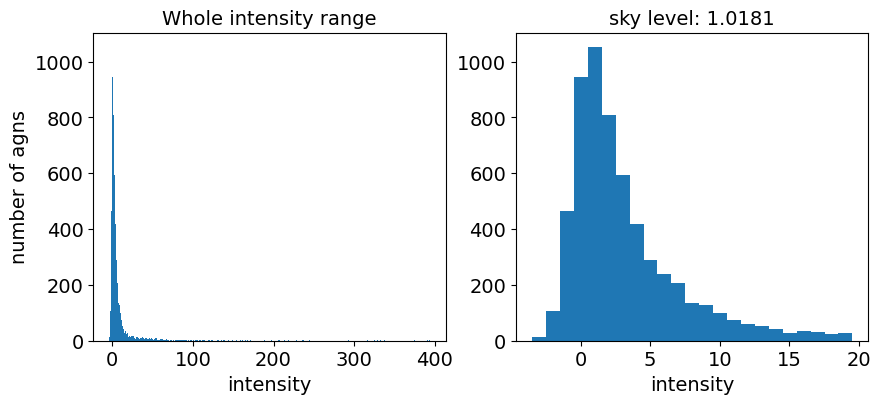

In [3]:
on = "J0813+0905"
#imageFile = "../cutouts/data/"+on+".fits"
imageFile = "../cutouts/box/boxsize_"+on+"/"+on+"_80.fits"
imageAGN = fits.getdata(imageFile)
with open("../psfConstruction/psf_pkls/psf_"+on+".pkl","rb") as f:
    d = pickle.load(f)
epsf = d['psf'].data

# cropping image and find centers
#imageAGN, ys, xs = crop_image(imageAGN,size=10)
ys,xs = find_highest_indices(imageAGN)
Imax = imageAGN.max()
itot=1500
framelim = imageAGN.shape[0]
midF=framelim//2

# for testing 1 model at a time
def make1model(xpos,ypos,function_dict,psf,dataImage):
    func_set_dict = {'X0': xpos, 'Y0': ypos, 
                    'function_list': [function_dict]}
    funcset = [func_set_dict]
    model= pyimfit.ModelDescription.dict_to_ModelDescription({'function_sets':funcset})
    fitter = pyimfit.Imfit(model,psf=psf)
    return fitter


sersic_dict, psf_dict, gaussian_dict, flatsky_dict, flatbar_dict, exp_dict = makeModelDict(PA_ss=200, ell_ss=0.1, n_ss=1, I_ss=1, r_ss=20, Itot=itot,
                                                                     PA_lim=[0,360], ell_lim=[0.0,1.0], I_lim=[0.1,Imax],
                                                                     Iss_lim=[0.1,Imax], rss_lim=[0.1,framelim], Itot_lim=[0.1,1e4],
                                                                     sigma = 5, sigma_lim = [1,20], Isky = 2.5, Isky_lim =[0,10],
                                                                     h1=10,h2=10,h_lim=[0.1,framelim],alpha=0.1,alpha_lim=[0.1,framelim])


# make models
hlim_max=1000
models_n1 = galaxy_model(X0=xs[0], Y0=ys[0], 
                         X1=xs[1], Y1=ys[1], 
                         Xss0=xs[0], Yss0=ys[0], 
                         Xss1=xs[1], Yss1=ys[1],
                         Xlim=[0,framelim], Ylim=[0,framelim], Xsslim = [0,framelim], Ysslim=[0,framelim],
                         PA_ss=200, ell_ss=0.1, n_ss=1, I_ss=1, r_ss=20, Itot=itot,
                         PA_lim=[0,360], ell_lim=[0.0,1.0], I_lim=[0.1,Imax],
                         Iss_lim=[0.1,Imax], rss_lim=[0.1,framelim], Itot_lim=[0.1,1e4],
                         sigma = 5, sigma_lim = [1,20],midf=midF, Isky = 2.5, Isky_lim =[0,10],
                         h1=10,h2=10,h_lim=[0.1,hlim_max],alpha=0.1,alpha_lim=[0.1,framelim])

sky = find_sky(imageAGN,plothist=True)


In [70]:
def profile_1D(semiA,image,PA=180,ell=0.5):
    """make 1D elliptical profiles"""
    # create guess ellipse
    pos0 = image.shape[0]//2
    geometry = EllipseGeometry(x0=pos0, y0=pos0, sma=semiA, eps=ell,
                               pa=PA * np.pi / 180.0)
    # load image and geometry
    ellipse = Ellipse(image, geometry)
    # do isophote fit
    isolist = ellipse.fit_image()
    return isolist


def plot_isophotes(ax,isolist,num_aper=10):
    """plot aperatures on image"""
    for sma in np.linspace(isolist.sma[0],isolist.sma[-1],num_aper):
        iso = isolist.get_closest(sma)
        x, y, = iso.sampled_coordinates()
        ax.plot(x, y, color='white',linewidth="0.5")
        
        
def make_model_components(config,imshape):
    """make model component images from best fit config"""
    comp_names = config.functionLabelList()
    comp_ims=[]
    comp_pos = []
    for i in range(len(config.getModelAsDict()['function_sets'])):
        posX = config.getModelAsDict()['function_sets'][i]['X0']
        posY = config.getModelAsDict()['function_sets'][i]['Y0']
        functions = config.getModelAsDict()['function_sets'][i]['function_list']
        for j in range(len(functions)):
            funcset_dict = {'X0': posX, 'Y0': posY, 'function_list': [functions[j]]}
            model_dict = {'function_sets': [funcset_dict]}
            model = pyimfit.ModelDescription.dict_to_ModelDescription(model_dict)
            imfit_fitter = pyimfit.Imfit(model,epsf)
            comp_ims.append(imfit_fitter.getModelImage(shape=(imshape,imshape)))
            comp_pos.append([posX[0],posY[0]])
    return comp_ims, comp_pos, comp_names


def plot_model_components(comp_ims,comp_names,isolist_comps,plot_iso=False):
    """plot 2D model components and check residual with model image"""
    ncom = len(comp_names)
    fig,ax = plt.subplots(nrows=1,ncols=ncom+1, figsize=(ncom*3+3,3))
    im = [ax[i].imshow(comp_ims[i],norm='symlog') for i in range(ncom)]
    [ax[i].set_title(comp_names[i]) for i in range(ncom)]
    im.append(ax[-1].imshow(np.sum(comp_ims[:-1],axis=0)-comp_ims[-1],norm='symlog'))
    ax[-1].set_title("model-comps")
    [fig.colorbar(im[i], ax=ax[i], shrink=0.7).ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f')) for i in range(len(ax))]
    if plot_iso:
        for i in range(len(isolist_comps)):
             plot_isophotes(ax[i],isolist_comps[i],num_aper=5)
    fig.tight_layout();
    
    


ModelObjectWrapper: about to call _model.CreateModelImage()...
ModelObjectWrapper: about to call _model.CreateModelImage()...
36206.26751796296


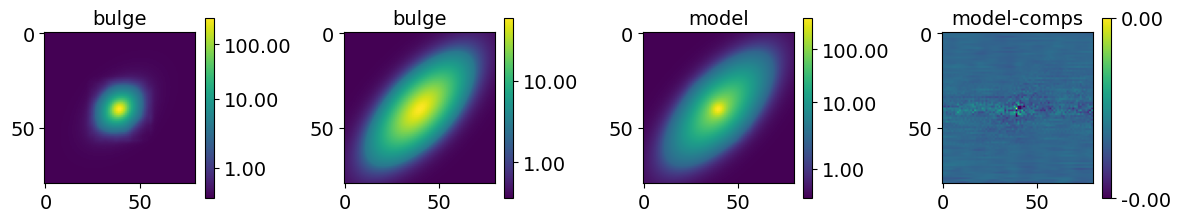

In [74]:
with fits.open("../../agn-data/2020-02-22_J_J0813+0905_c1-4_58901_06308.mos.fits") as hdul:
    hdu = hdul[0]

sky_level = hdu.header['BACKGND'] #[e-/s] native pixels, value should be in the same units as the data pixels

with fits.open("2020-02-22_J_J0813+0905_c1-4_58901_06308.exp.fits") as hdul:
    hdu = hdul[0]
exptime= hdu.header['EXPOSURE'] # actual exp time
gain = hdu.header['EGAIN'] #[e-/DU] in header
noise=hdu.header['EFFRN'] #[e-] in header
numcom=hdu.header['NCOADD'] #Number of Averaged Frames   
# Try for only 1 model
imageAGN_bs = imageAGN-sky
image = imageAGN_bs
modelname = '2sersic'
config0, modelIm0, fitRes0, pname0,fitter0  = dofit_no_oversp(modelname,dataImage=image, psf=epsf,solver="LM",gainlev=gain,
                                                  readnoise=noise, expT=exptime, skylevel = sky_level, ncom=numcom)
m = modelIm0
res = fitRes0.params
pname = pname0
fs = fitRes0.fitStat
comp_ims, comp_pos, comp_names = make_model_components(config0,imshape=image.shape[0])
comp_ims.append(m)
comp_names.append("model")
# make model components
plot_model_components(comp_ims,comp_names,[])
print(fs)

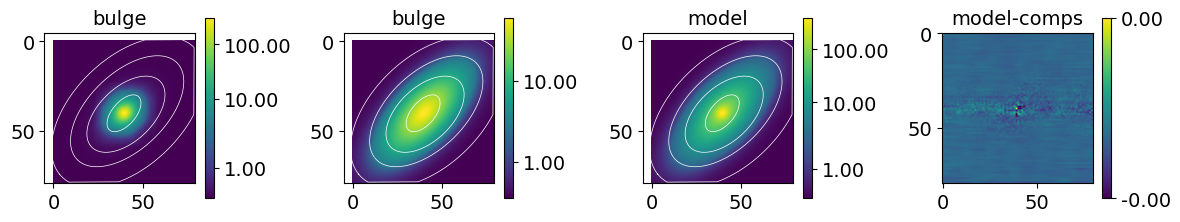

In [75]:
isolist_data = profile_1D(semiA=20,image=imageAGN_bs)

X0 = isolist_data.x0
Y0 = isolist_data.y0
PA = isolist_data.pa
smax = isolist_data.sma
ell = isolist_data.eps

isolist_comps = []

for j in range(len(comp_ims)):
    if comp_names[j] == "psf":
        geometries=[EllipseGeometry(x0=X0[i], y0=Y0[i], sma=smax[i], eps=0,
                            pa=0,fix_center=True, 
                            fix_pa=True, fix_eps=True) for i in range(len(X0))]
    else:
        geometries=[EllipseGeometry(x0=X0[i], y0=Y0[i], sma=smax[i], eps=ell[i],
                            pa=PA[i],fix_center=True, 
                            fix_pa=True, fix_eps=True) for i in range(len(X0))]
    # list to store all isophote for 1 profile
    isolist = IsophoteList([])
    for i in range(len(geometries)):
        ellipse = Ellipse(comp_ims[j], geometries[i])
        if i==0:
            isolist.append(ellipse.fit_isophote(sma=geometries[i].sma))
        else:
            # some how not iterating helps w error?
            isolist.append(ellipse.fit_isophote(sma=geometries[i].sma,noniterate=True))
    isolist_comps.append(isolist)
    
plot_model_components(comp_ims,comp_names,isolist_comps,plot_iso=True)

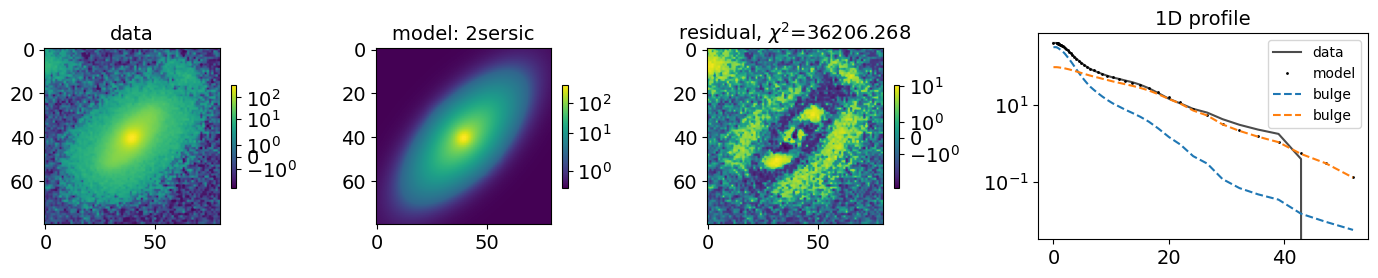

In [76]:
# plot everything 
fig,ax = plt.subplots(1,4,figsize=(14,3),gridspec_kw={'width_ratios': [1, 1, 1, 1.5]})
#norms = [simple_norm([image, m, image-m][i],'log') for i in range(3)]
im = [ax[i].imshow([image, m, image-m][i], norm='symlog') for i in range(3)]
cbar = [fig.colorbar(im[i],ax=ax[i],shrink=0.5) for i in range(3)]
[ax[i].set_title(['data',f"model: {modelname}",f'residual, $\chi^2$={fs:.3f}'][i]) for i in range(3)]

ax[-1].plot(isolist_data.sma,isolist_data.intens,label="data",c="k",alpha=0.7)
ax[-1].plot(isolist_comps[-1].sma,isolist_comps[-1].intens,c='k',linestyle="",marker="o",markersize=1,label="model")
[ax[-1].plot(isolist_comps[i].sma,isolist_comps[i].intens,label=comp_names[i],linestyle="--") for i in range(len(comp_ims)-1)]
ax[-1].set_yscale('log')
ax[-1].set_title("1D profile")
ax[-1].legend(fontsize=10);

fig.tight_layout();

Text(1, 1, '$\\chi^2$:37.50')

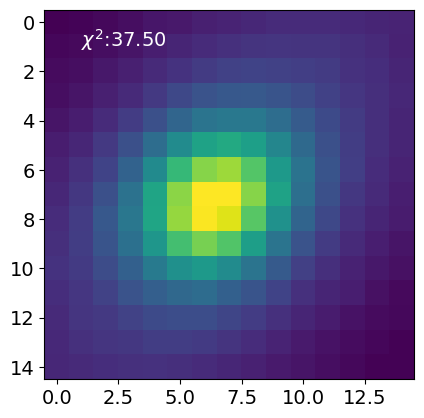

In [56]:
x = 51
y = 66
imcrop = image[x:y,x:y]
modelcrop = m[x:y,x:y]
plt.imshow(imcrop)
chi2=np.sum((modelcrop - imcrop)**2/ imcrop)
plt.text(x=1,y=1,s=f"$\chi^2$:{chi2:.2f}",c="w")

# plot fit files

In [6]:
#-------------plotting
def get_mcomps(d, psf_dict,sersic_dict):
    """make model components"""
    params = [d["fitResults"][i].params for i in range(len(d["fitResults"]))]
    mcomps = {}
    mcomps['1psf'] = [[psf_dict], [params[0]]]
    mcomps['1psf+sersic'] = [[psf_dict, sersic_dict], [params[1][:3], np.delete(params[1],2)]]
    mcomps['2psf'] = [[psf_dict, psf_dict], [params[2][:3], params[2][3:]]]
    mcomps['1psf+sersic,1psf'] = [[psf_dict, psf_dict, sersic_dict], [params[3][:3], params[3][3:6], np.delete(params[3][3:],2)]]
    mcomps['2psf+sersic,sameCenter'] = [[psf_dict,psf_dict,sersic_dict,sersic_dict], [params[4][:3],params[4][8:11], np.delete(params[4][:8],2), np.delete(params[4][8:],2)]]
    mcomps['1psf+sersic,diffCenter'] = [[psf_dict, sersic_dict],[params[5][:3], params[5][3:]]]
    return mcomps


def get_comps(model_dicts,newparams,epsf):
    """make model component images"""
    n_comps = len(model_dicts)
    model_images = []
    for i in range(len(model_dicts)):
        fitter = make1model(20,20,model_dicts[i],psf=epsf)
        mi = fitter.getModelImage(shape=[40,40],newParameters=newparams[i])
        model_images.append(mi) 
    return n_comps,model_images


def plot_comps(image,n_comps,model_images,mnum):
    """plot model components"""
    fig,ax = plt.subplots(3,4,figsize=(16,9))
    modelcomps = np.sum(model_images, axis=0)
    comp_resi = modelcomps-d['modelImage'][mnum]
    for i in range(len(model_images)):
        im = ax[0,i].imshow(model_images[i])
        im1 = ax[1,i].imshow(image-model_images[i])
        im2 = ax[2,i].imshow(image-np.sum(model_images[:i+1], axis=0))
        fig.colorbar(im, ax=ax[0,i], shrink=0.5)
        fig.colorbar(im1, ax=ax[1,i], shrink=0.5)
        fig.colorbar(im2, ax=ax[2,i], shrink=0.5)
    full_title_list = [['psf1'],['psf','sersic'],['psf1','psf2'],
                       ['psf1','psf2','sersic1'],['psf1','psf2','sersic1','sersic2'],
                       ['psf','sersic']]
    [ax[0,i].set_title(full_title_list[mnum][i]) for i in range(n_comps)]
    [ax[1,i].set_title("image $-$ "+full_title_list[mnum][i]) for i in range(n_comps)]
    ax[0,0].text(0.05,0.05, f"\% I_res: {np.sum(comp_resi):.2f}", transform=ax[0,0].transAxes,fontsize=14, color='w')
    [[ax[j,-i].axis('off') for i in range(1,4-n_comps+1)] for j in range(3)]
    fig.suptitle(list(d['modelNames'].keys())[mnum])
    fig.subplots_adjust(hspace=0.4,wspace=0.2)
    
    
def make_plot_comps(d, psf_dict, sersic_dict):
    mcomps = get_mcomps(d, psf_dict,sersic_dict)
    for mname,n in zip(mcomps,np.arange(len(d['modelNames']))):
        n_comps,model_images = get_comps(mcomps[mname][0],mcomps[mname][1],epsf)
        plot_comps(image,n_comps,model_images,n)

    
def plot_fit_result(d,figtitle,plot2best=False):
    image = d['imageSS']
    modelNum = len(d['fitResults'])
    fitStats = [d['fitResults'][i].fitStatReduced for i in range(modelNum)]
    best_2ind = np.argsort([d['fitResults'][i].fitStatReduced for i in range(modelNum)])[:2]
    if plot2best:
        nrows = 2
        ff = [best_2ind, np.arange(2)] 
    else:
        nrows = modelNum
        ff = [np.argsort(fitStats),np.arange(nrows)]   
    ncols=3 
    fig,ax = plt.subplots(nrows,ncols,figsize=(ncols*3,nrows*3))  
    for i, j in zip(ff[0],ff[1]):
        resi = image-d['modelImage'][i]
        im0 = ax[j,0].imshow(resi)
        im1 = ax[j,2].imshow(d['modelImage'][i])
        im2 = ax[j,1].imshow(image)
        [fig.colorbar([im0,im1,im2][k], ax=ax[j,k], shrink=0.7) for k in range(ncols)]
        rmsNoise = np.sqrt(np.sum(resi**2)/image.shape[0]**2)
        iRatio = np.sum(resi)/np.sum(image)*100
        ax[j,2].text(0.05, 0.25, f"$\chi^2$:{fitStats[i]:.2f}", transform=ax[j,2].transAxes, fontsize=10, color='w')
        ax[j,2].text(0.05, 0.15, f"noise RMS:{rmsNoise:.2f}", transform=ax[j,2].transAxes, fontsize=10, color='w')
        ax[j,2].text(0.05, 0.05, f"% I_res: {np.abs(iRatio):.2f}", transform=ax[j,2].transAxes, fontsize=10, color='w')
        title = list(d['modelNames'].keys())[i]
        title = '\n'.join(title.split(',', 1)) if len(title) > 15 else title
        ax[j,2].set_title(title, fontsize=10)
        ax[j,0].set_title("residual", fontsize=10)
        ax[j,1].set_title("data", fontsize=10)
    fig.suptitle(figtitle,y=0.99)
    fig.tight_layout(pad=0.9, h_pad=0, w_pad=1)
    #pdf.savefig()
    
    
    
def plot_radial_fit(d,agnCenter):
    dataImage = d['imageSS']
    modelNum = len(d['fitResults'])
    fitStats = [d['fitResults'][i].fitStat for i in range(modelNum)]
    bestind = np.argsort(fitStats)
    fig,ax = plt.subplots()
    #plot models rp
    for i in range(modelNum):
        param_names=d['paramNames'][i]
        param_vals = d['fitResults'][i].params
        dic = dict(zip(param_names, param_vals))
        # if model has 1 psf
        """
        if list(d['modelNames'].keys())[i].count("psf") == 1:
            cen = [dic["X0_1"]-1, dic['Y0_1']-1]
        else:
            cenup = np.array([dic["X0_1"]-1, dic['Y0_1']-1])
            cendown = np.array([dic["X0_2"]-1, dic['Y0_2']-1])
            cen = (cenup+cendown)/2
        """
        modelRP = profiles.RadialProfile(d['modelImage'][i],xycen=agnCenter,radii=np.arange(50))
        if i==bestind[0]:
            ax.plot(modelRP.radius, modelRP.profile, color='royalblue', label="best 5 models", lw=2)
        else:
            ax.plot(modelRP.radius, modelRP.profile, color='steelblue', label="other models", alpha=0.2)
        #ax.plot(mRP.radius, agn.profile-mRP.profile, color='b', label="residual")
    # plot data rp
    agnRP = profiles.RadialProfile(dataImage,xycen=agnCenter,radii=np.arange(50))
    ax.plot(agnRP.radius, agnRP.profile, 'ko', label="data",markersize=1)    
    ax.set_title("Radial profiles data and models (free n)")
    ax.set_xlabel("Radius(pixels)")
    ax.set_ylabel("Intensity(counts)") 
    #ax.set_ylim((0,150))

    legend_elements = [
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='k', markersize=5, label='data'),
        plt.Line2D([0], [0], color='royalblue', label='best model: '+list(d['modelNames'].keys())[bestind[0]]),
        plt.Line2D([0], [0], color='lightblue', label='other models')
    ]

    ax.legend(handles=legend_elements, fontsize=10);
    


In [77]:
on = "J0813+0905"
with open("../fit/fit_pkls/var_frame_size/"+on+".pkl", 'rb') as file:
    d = pickle.load(file)
    
with open ("../psfConstruction/psf_pkls/psf_"+on+".pkl", "rb") as f:
    p = pickle.load(f)
epsf = p['psf'].data
image = d['imageSS']
print(d.keys())
#n = 1
#[print(f"{paramnames[n][i]}: {params[n][i]}") for i in range(len(paramnames[n]))];

dict_keys(['imageSS', 'modelNames', 'configs', 'modelImage', 'fitResults', 'paramNames'])


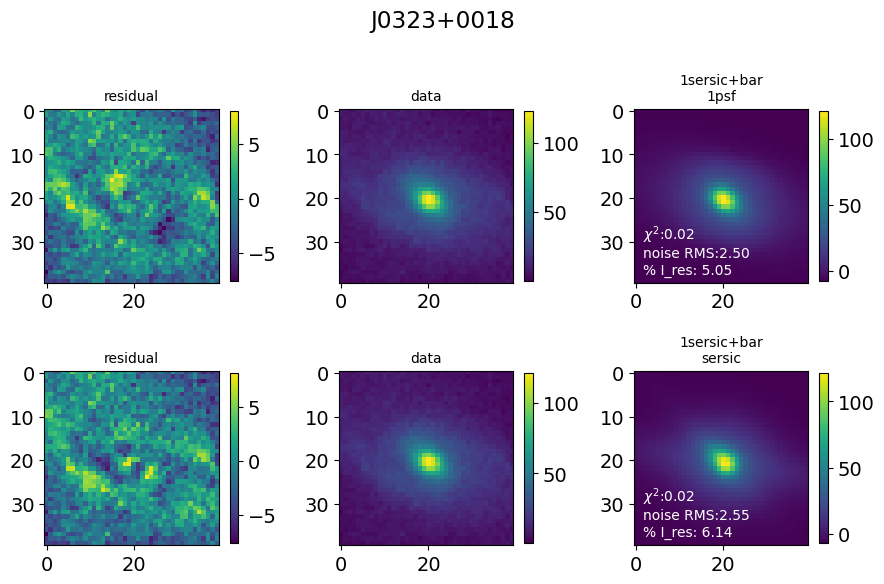

In [10]:
plot2best=True
image = d['imageSS']
modelNum = len(d['fitResults'])
fitStats = [d['fitResults'][i].fitStatReduced for i in range(modelNum)]
best_2ind = np.argsort([d['fitResults'][i].fitStatReduced for i in range(modelNum)])[:2]
if plot2best:
    nrows = 2
    ff = [best_2ind, np.arange(2)] 
else:
    nrows = modelNum
    ff = [np.argsort(fitStats),np.arange(nrows)]   
ncols=3 
fig,ax = plt.subplots(nrows,ncols,figsize=(ncols*3,nrows*3))  
for i, j in zip(ff[0],ff[1]):
    resi = image-d['modelImage'][i]
    im0 = ax[j,0].imshow(resi)
    im1 = ax[j,2].imshow(d['modelImage'][i])
    im2 = ax[j,1].imshow(image)
    [fig.colorbar([im0,im1,im2][k], ax=ax[j,k], shrink=0.7) for k in range(ncols)]
    rmsNoise = np.sqrt(np.sum(resi**2)/image.shape[0]**2)
    iRatio = np.sum(resi)/np.sum(image)*100
    ax[j,2].text(0.05, 0.25, f"$\chi^2$:{fitStats[i]:.2f}", transform=ax[j,2].transAxes, fontsize=10, color='w')
    ax[j,2].text(0.05, 0.15, f"noise RMS:{rmsNoise:.2f}", transform=ax[j,2].transAxes, fontsize=10, color='w')
    ax[j,2].text(0.05, 0.05, f"% I_res: {np.abs(iRatio):.2f}", transform=ax[j,2].transAxes, fontsize=10, color='w')
    title = list(d['modelNames'].keys())[i]
    title = '\n'.join(title.split(',', 1)) if len(title) > 15 else title
    ax[j,2].set_title(title, fontsize=10)
    ax[j,0].set_title("residual", fontsize=10)
    ax[j,1].set_title("data", fontsize=10)
fig.suptitle(on,y=0.99)
fig.tight_layout(pad=0.9, h_pad=0, w_pad=1)

'with open("fit_summary.txt","w") as f_write:\n    for i in range(len(fn)):\n        oname = fn[i].split(".")[0]\n        with open("../fit/fit_pkls/"+fn[i], "rb") as f:\n            d = pickle.load(f)\n        modelNum = len(d[\'fitResults\'])\n        fitStats = [d[\'fitResults\'][i].fitStatReduced for i in range(modelNum)]\n        best = np.argsort([d[\'fitResults\'][i].fitStatReduced for i in range(n_models)])[0]\n        bestname = list(d[\'modelNames\'])[best]\n        f_write.write(f\'{oname} : {bestname}\n\')'

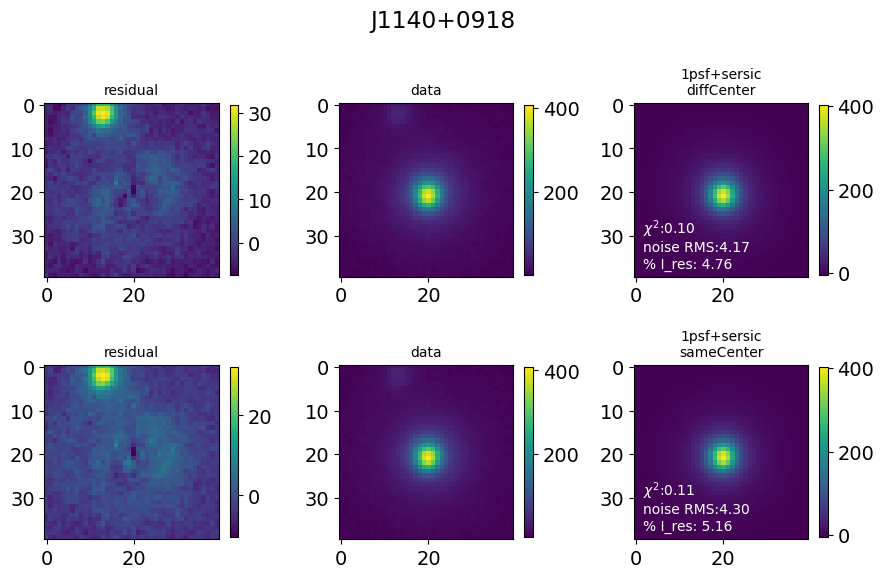

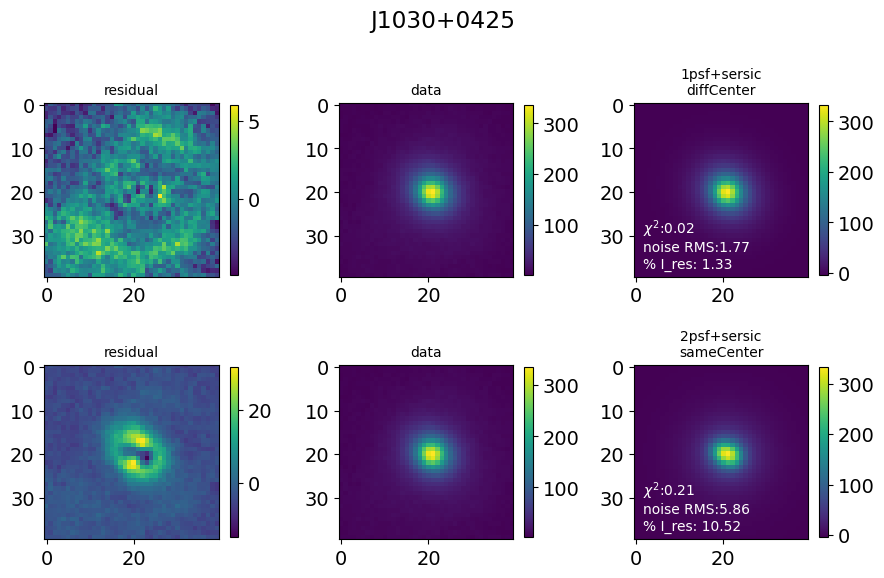

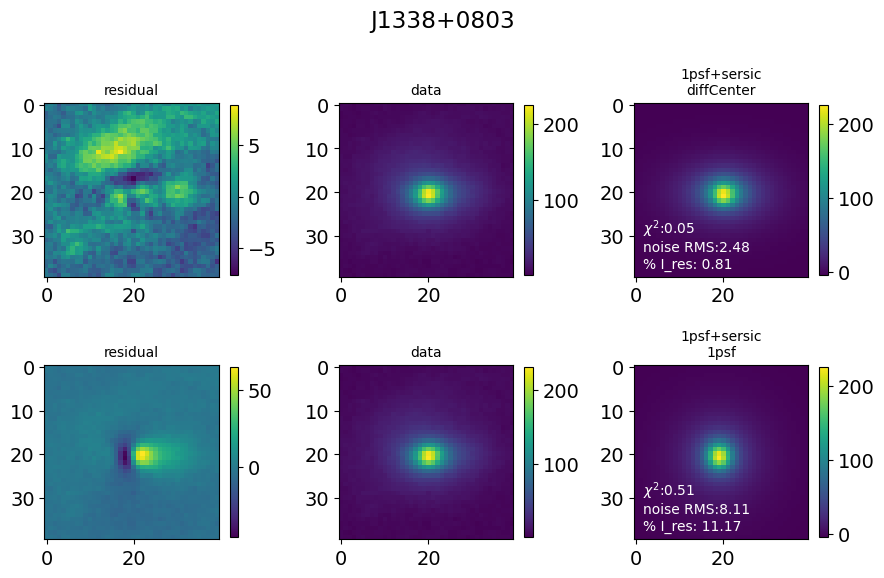

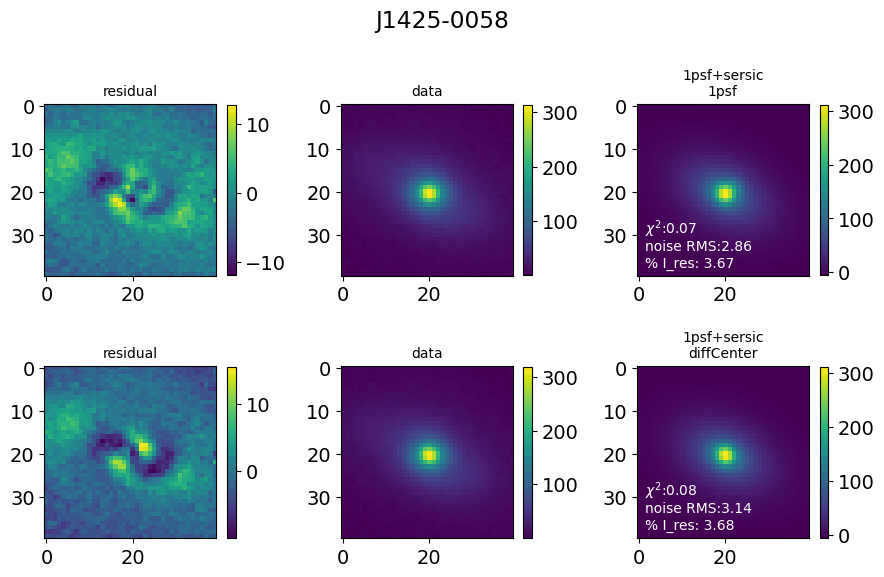

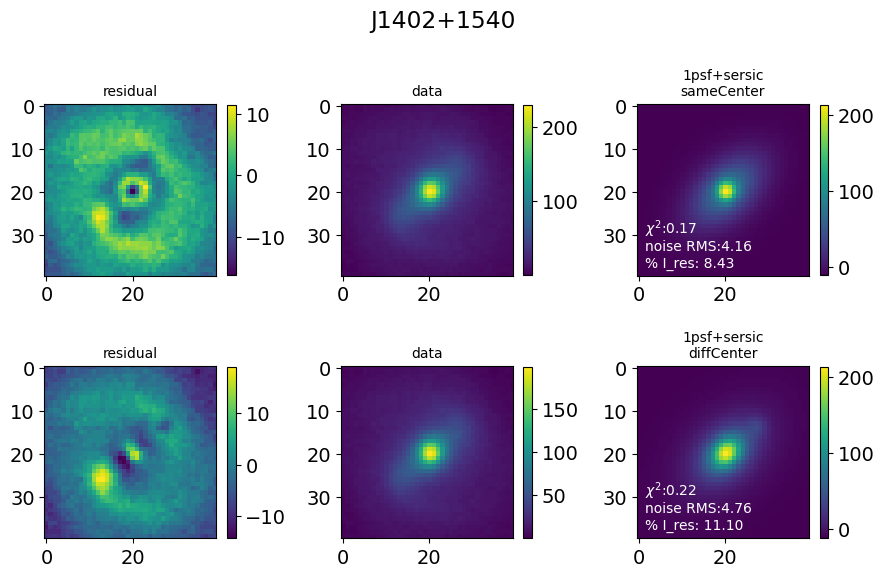

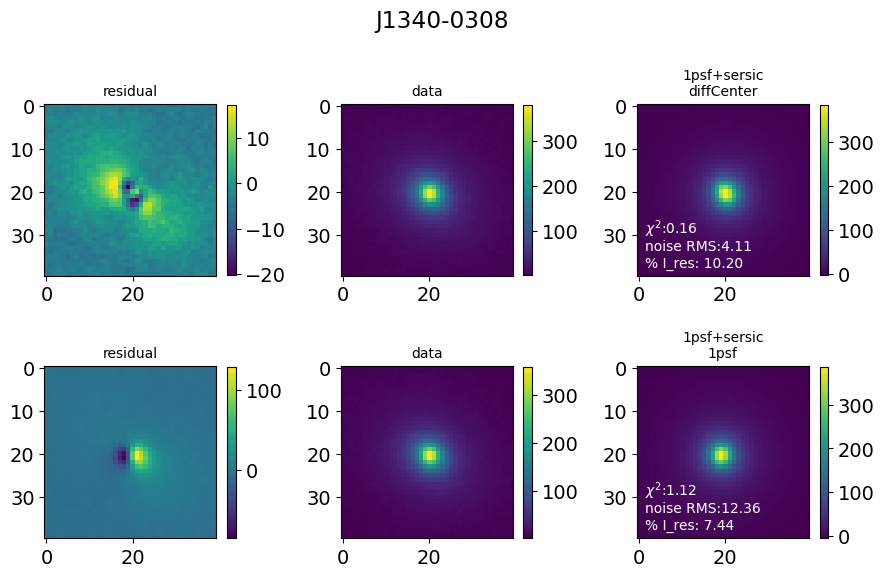

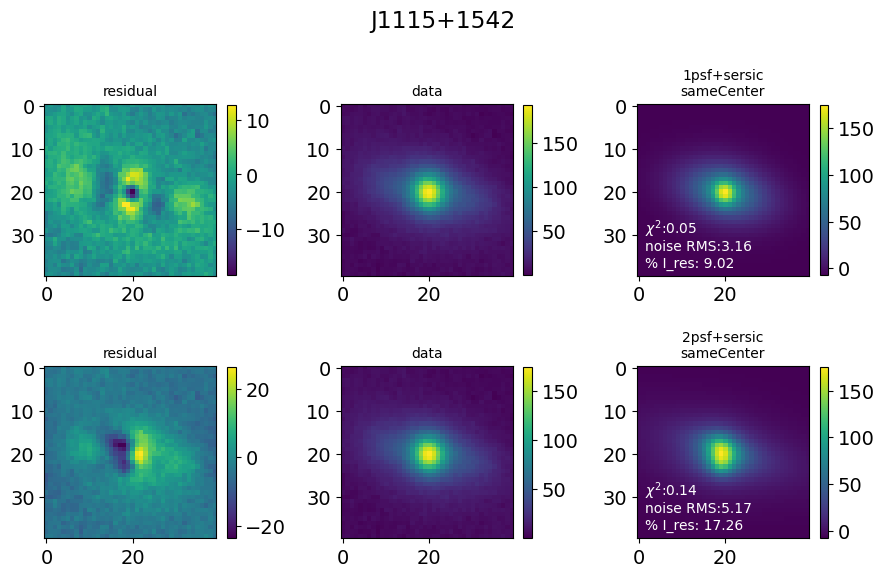

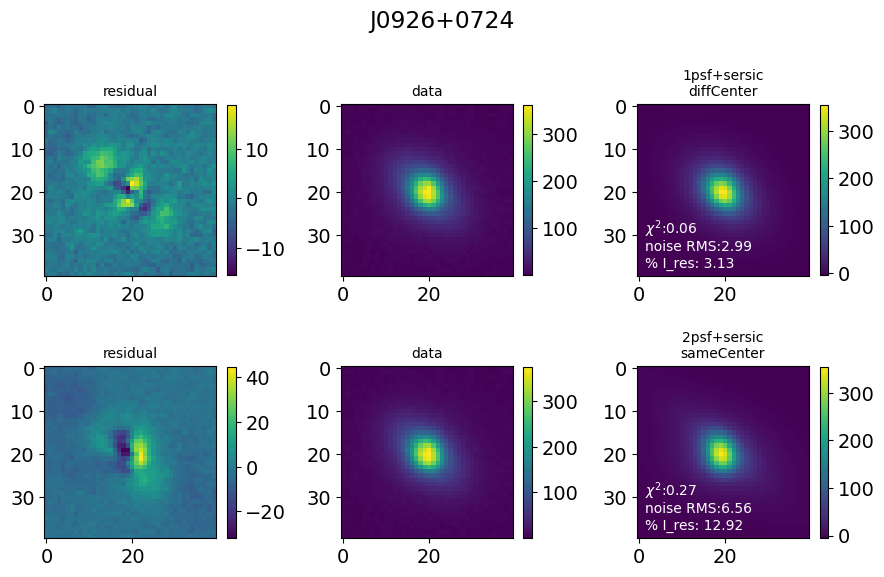

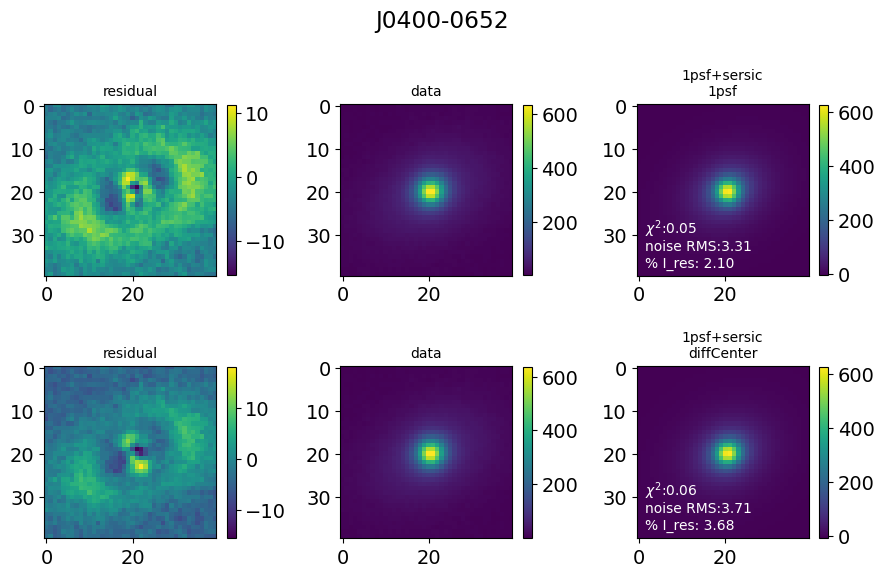

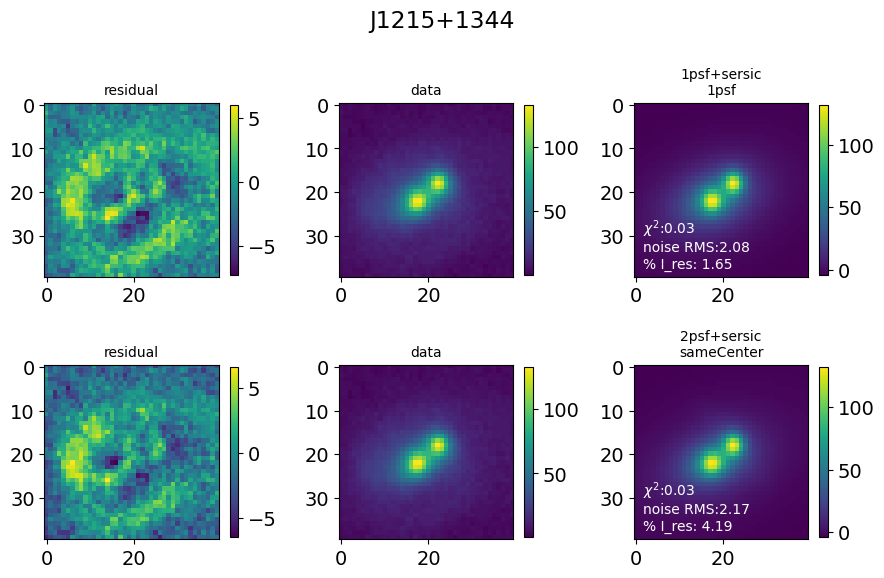

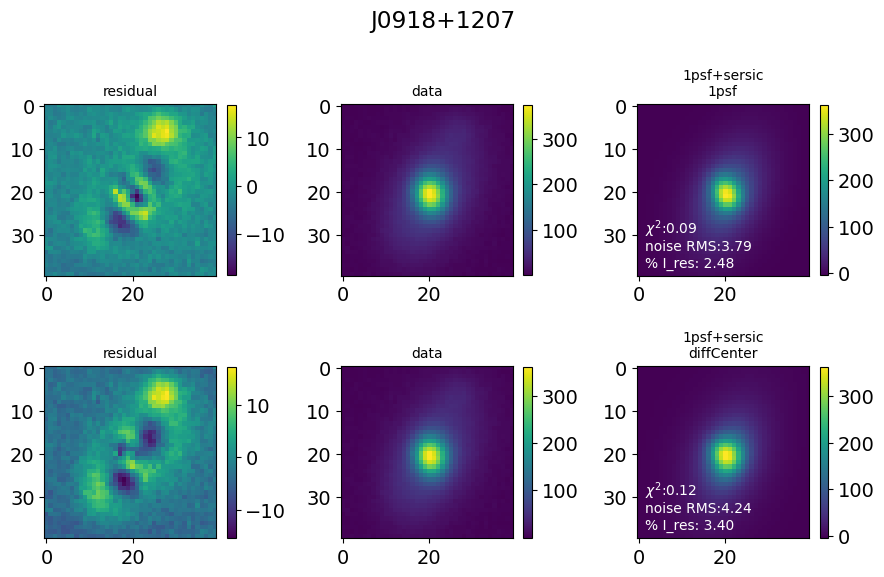

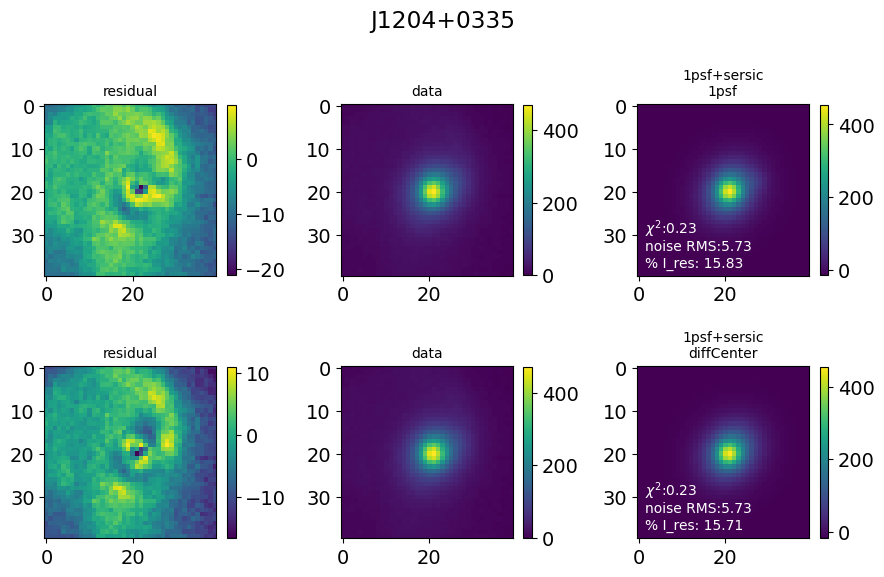

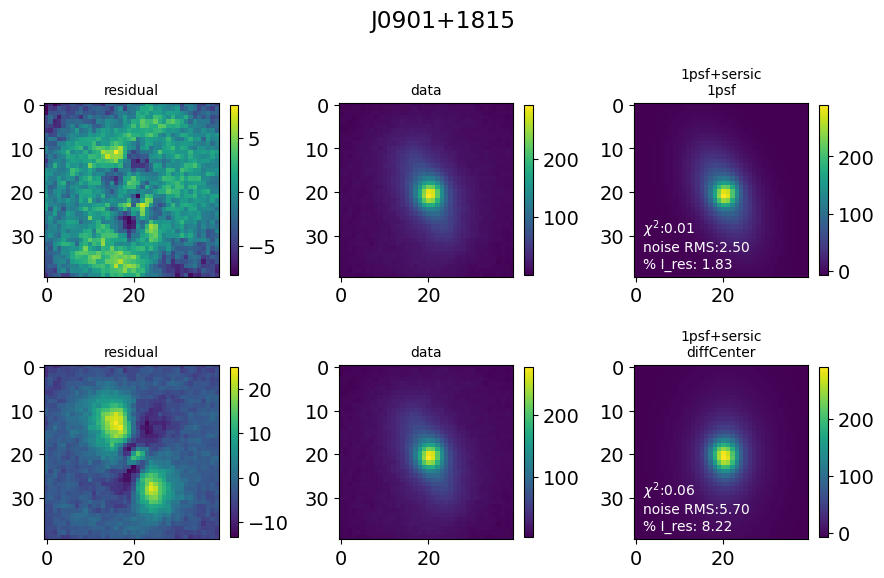

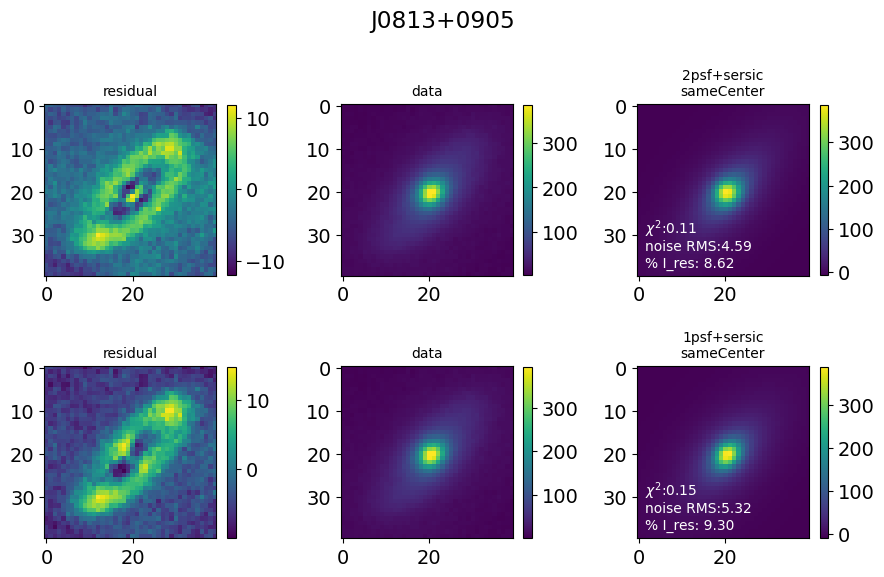

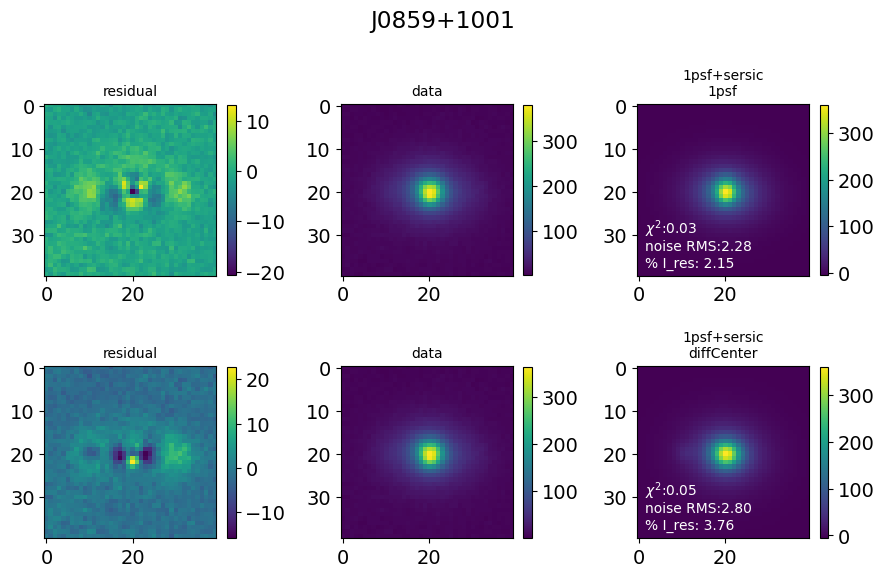

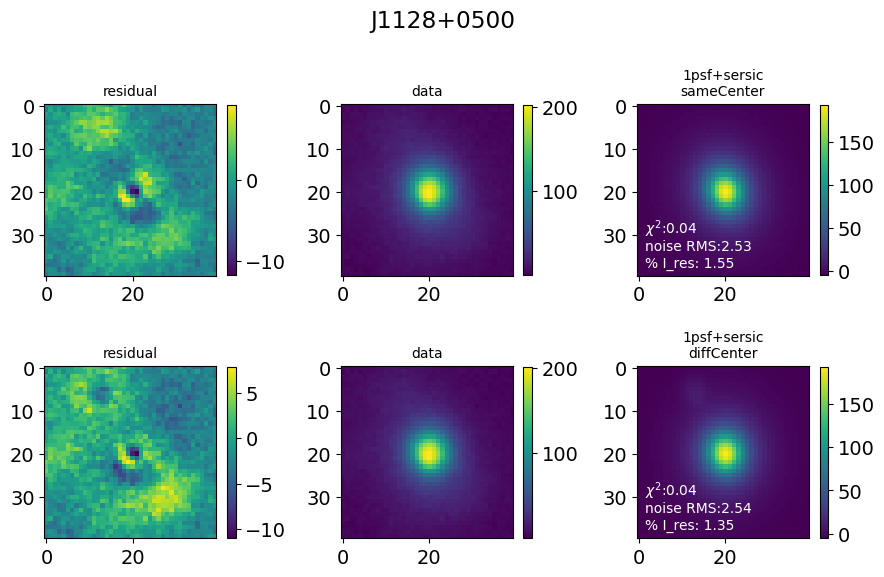

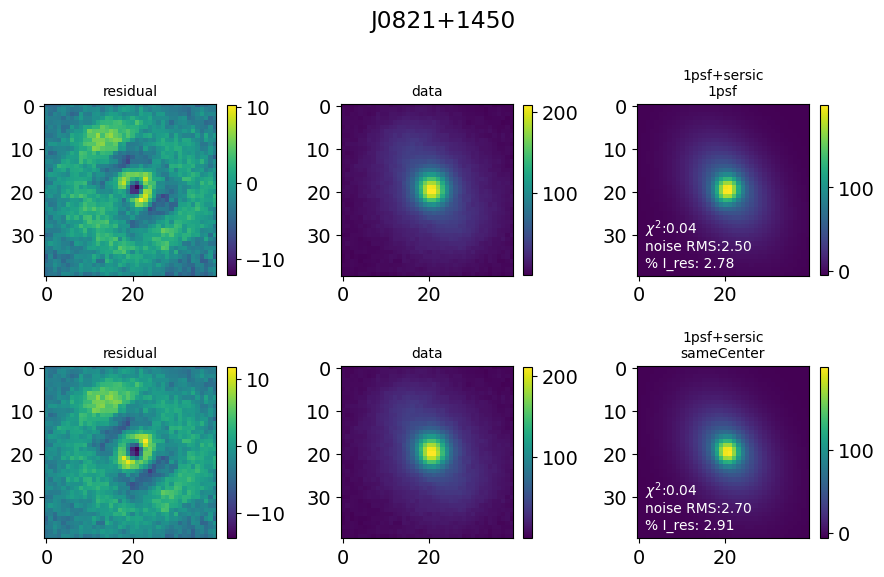

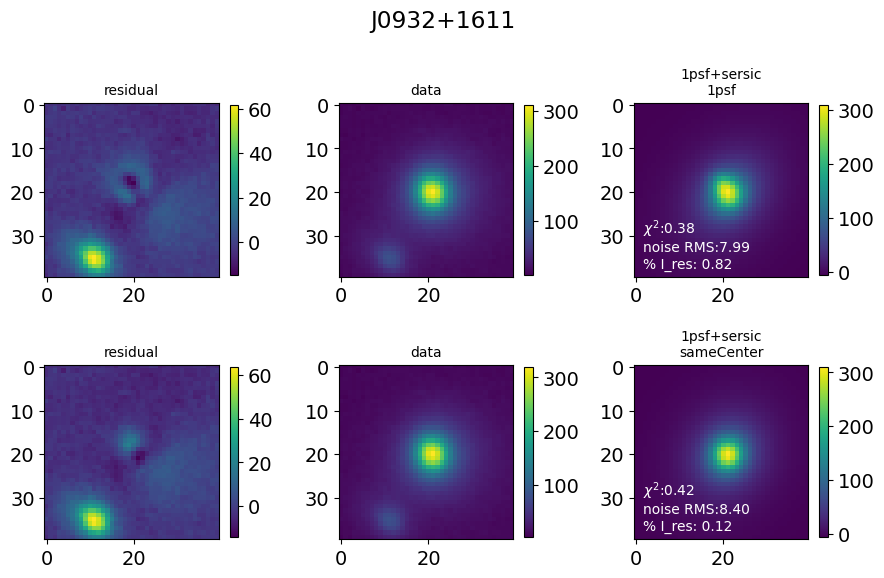

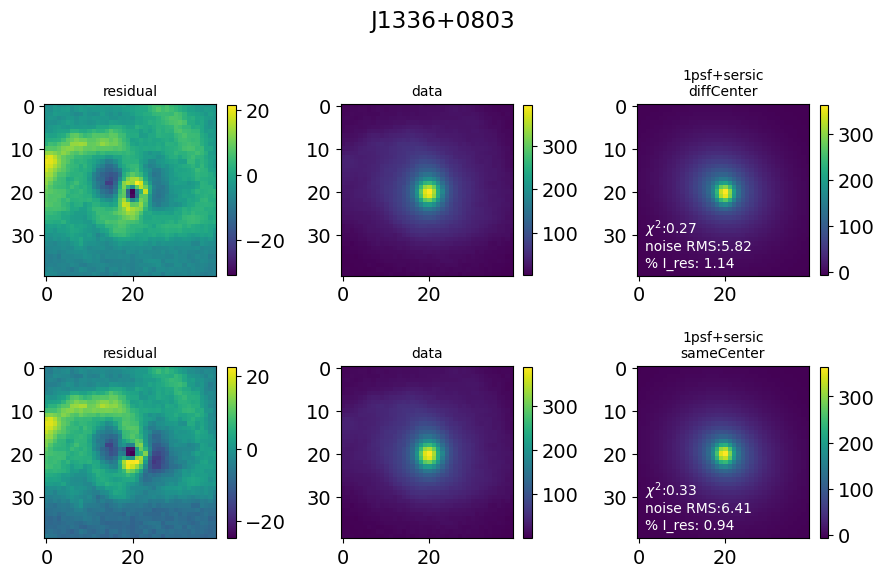

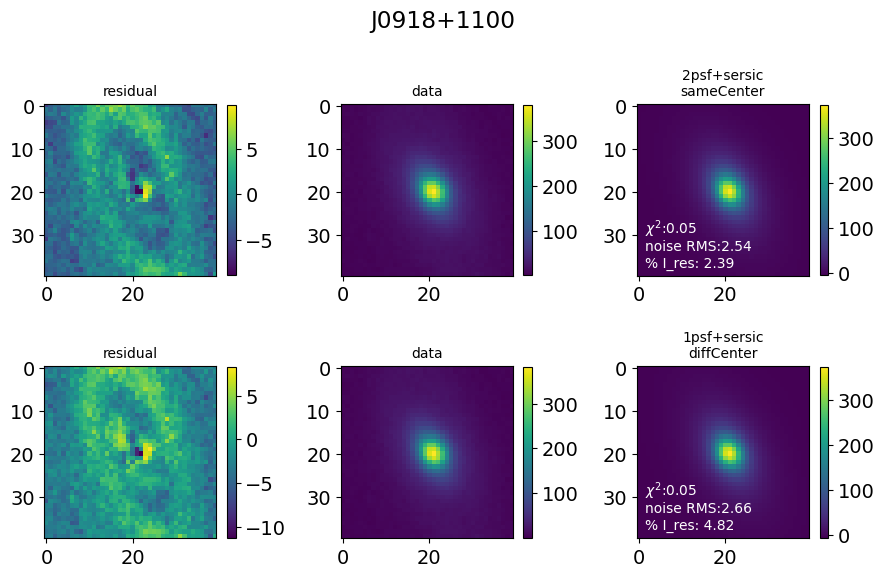

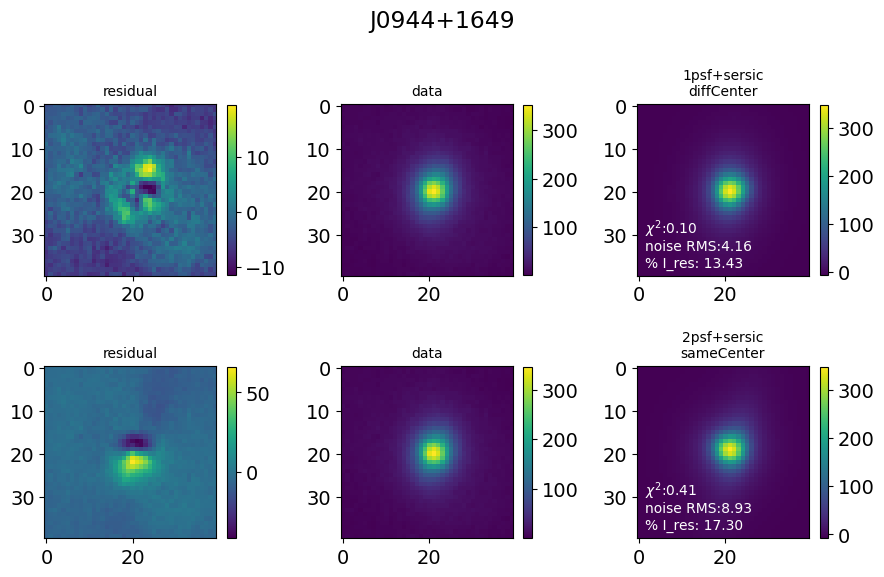

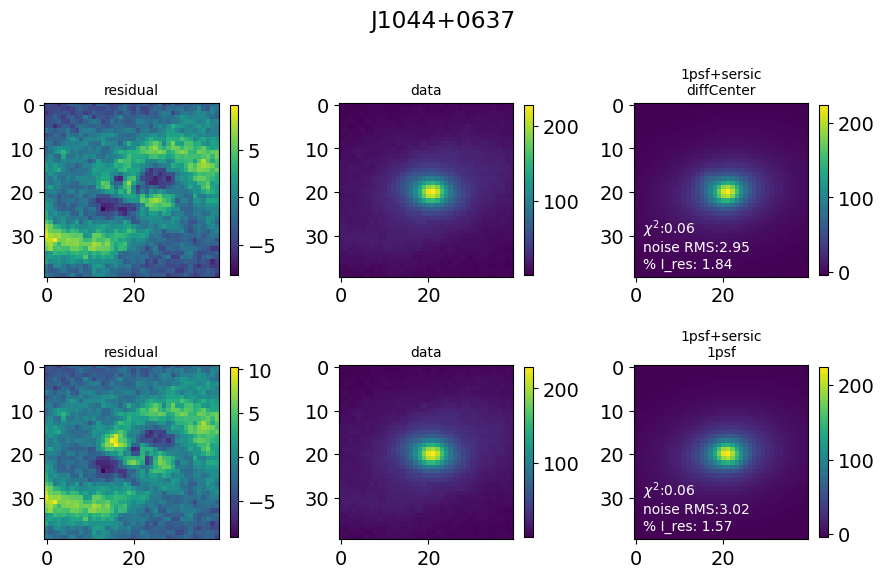

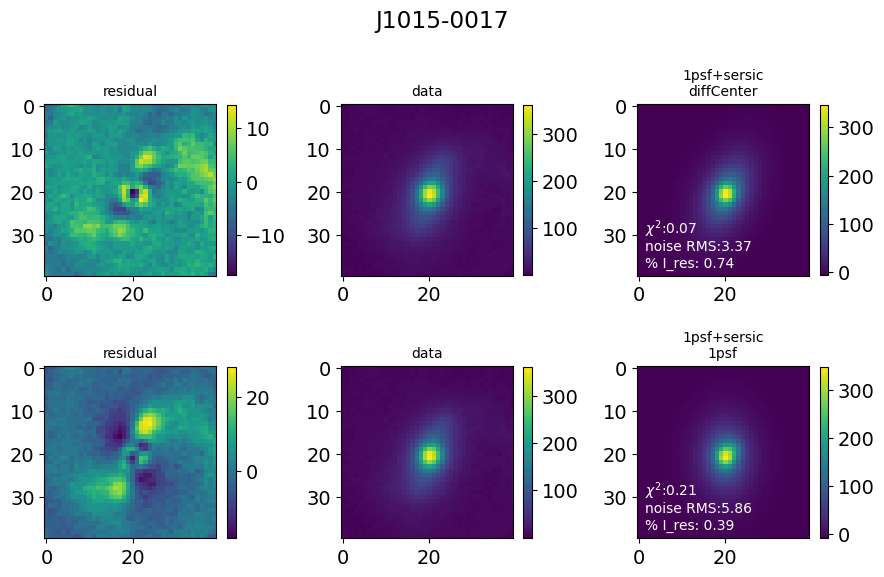

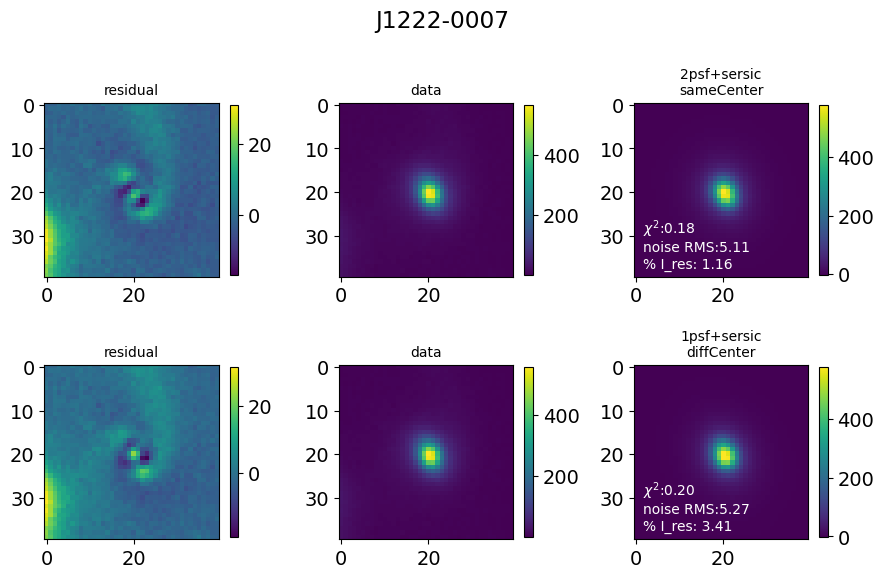

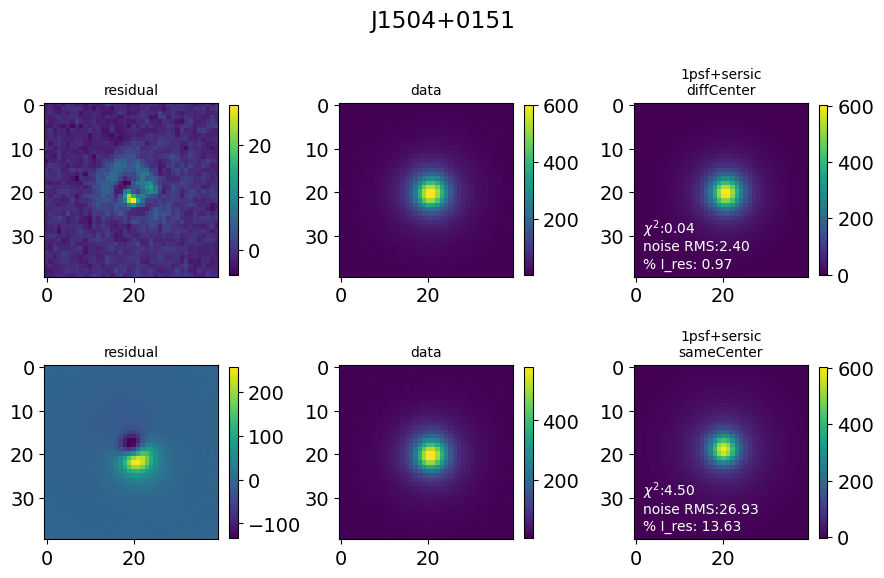

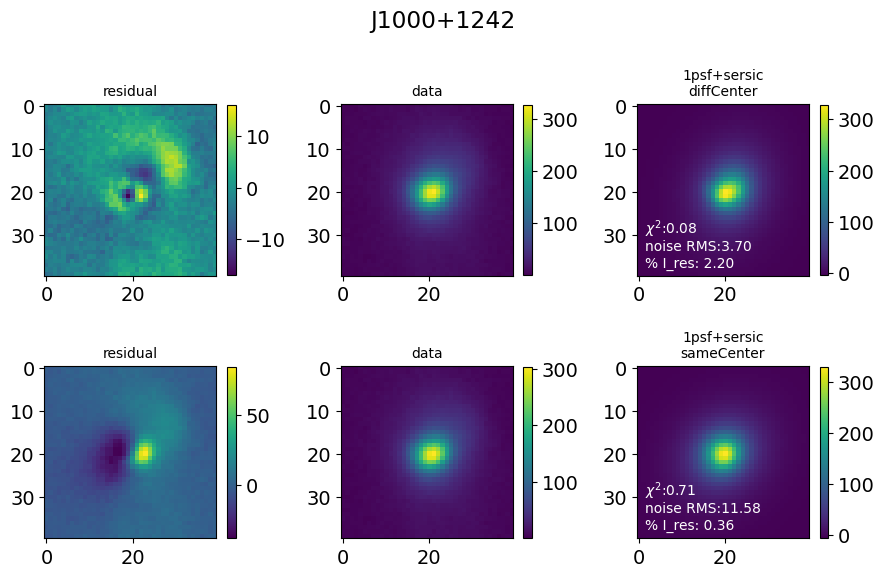

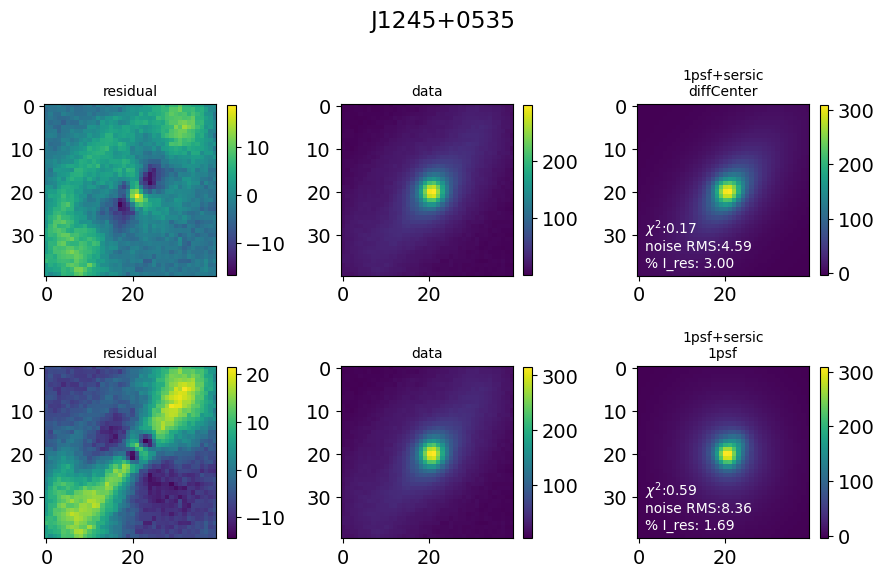

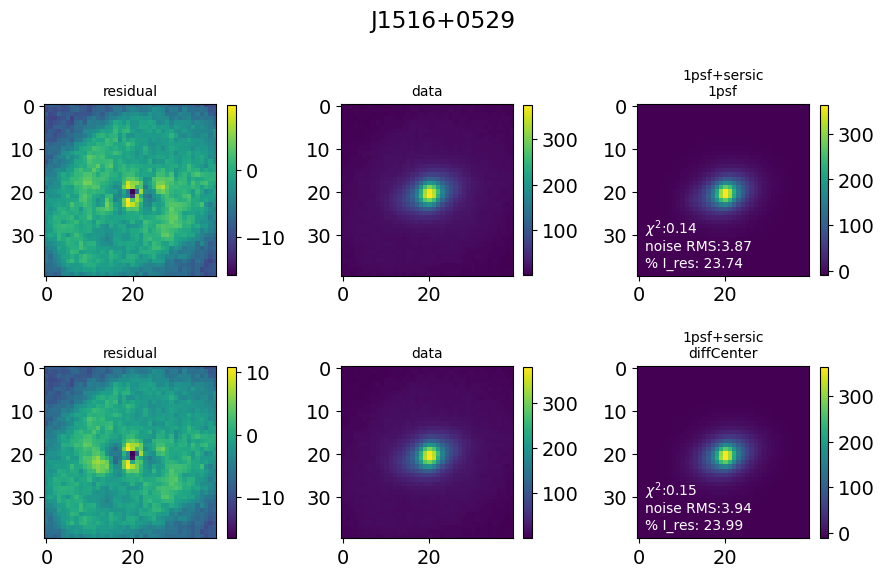

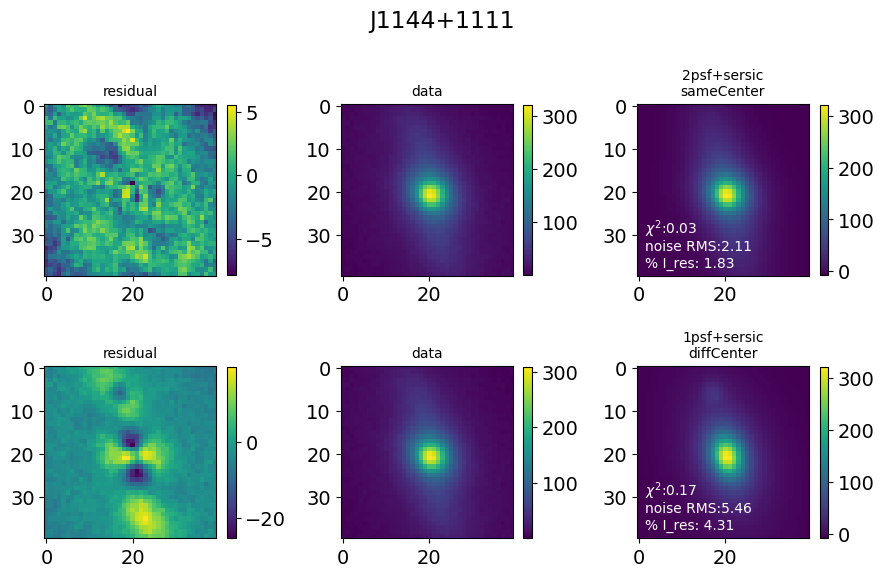

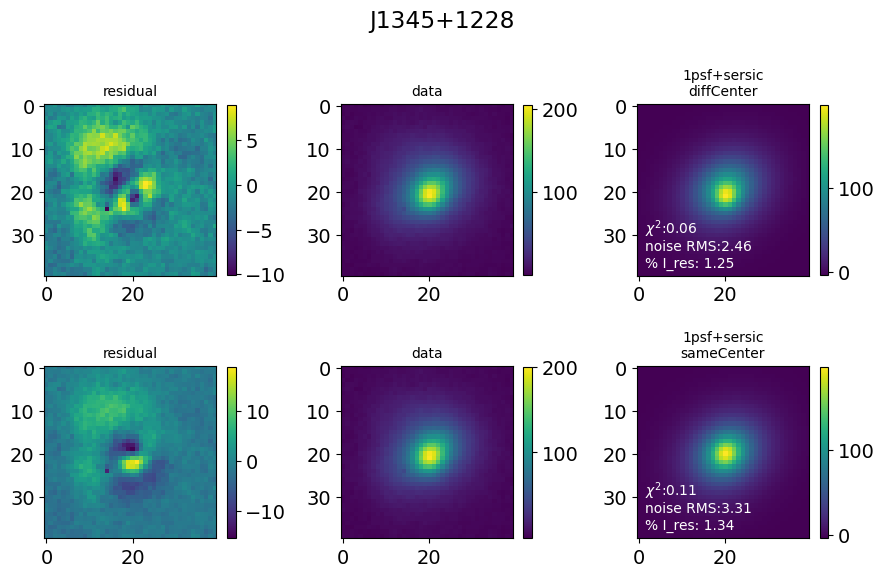

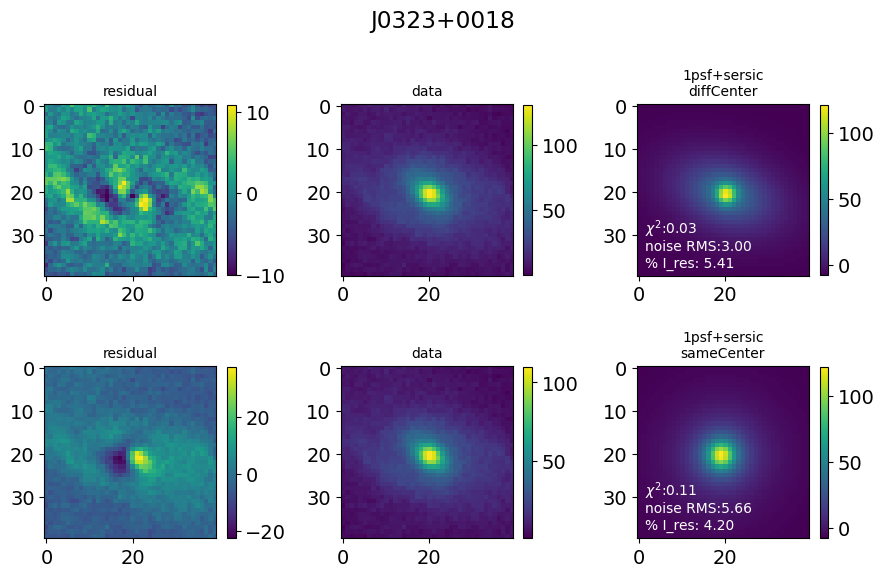

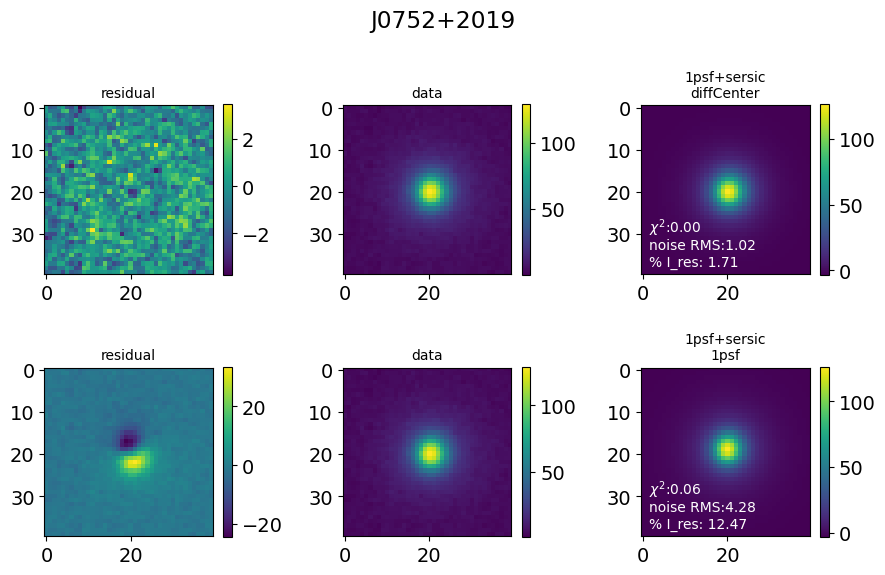

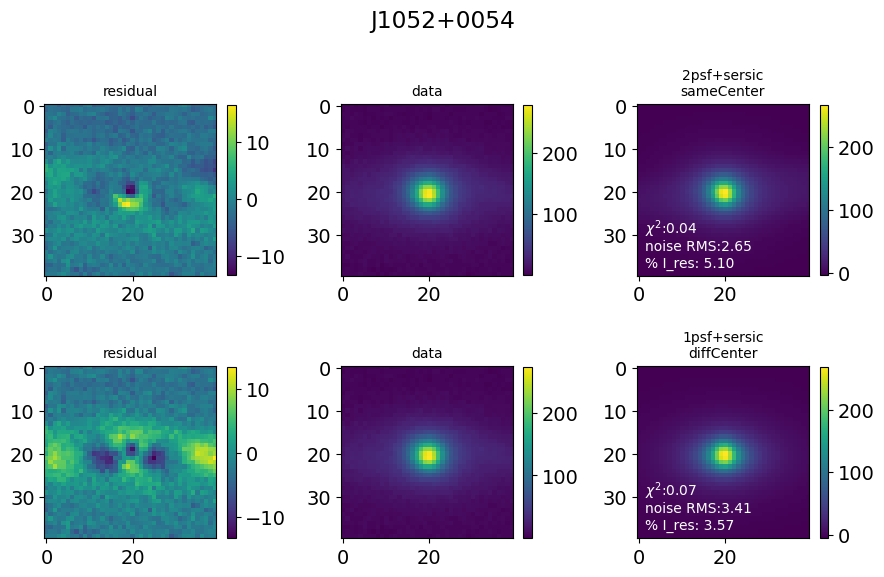

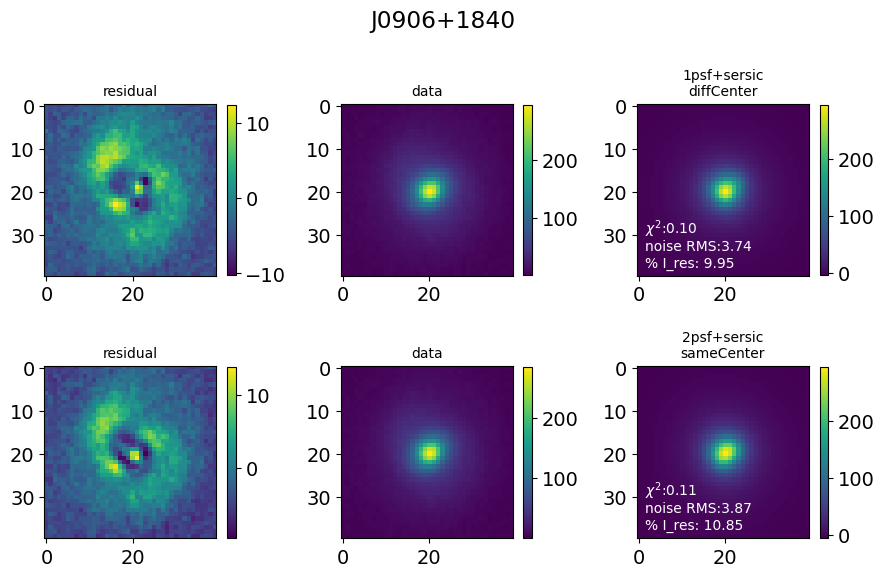

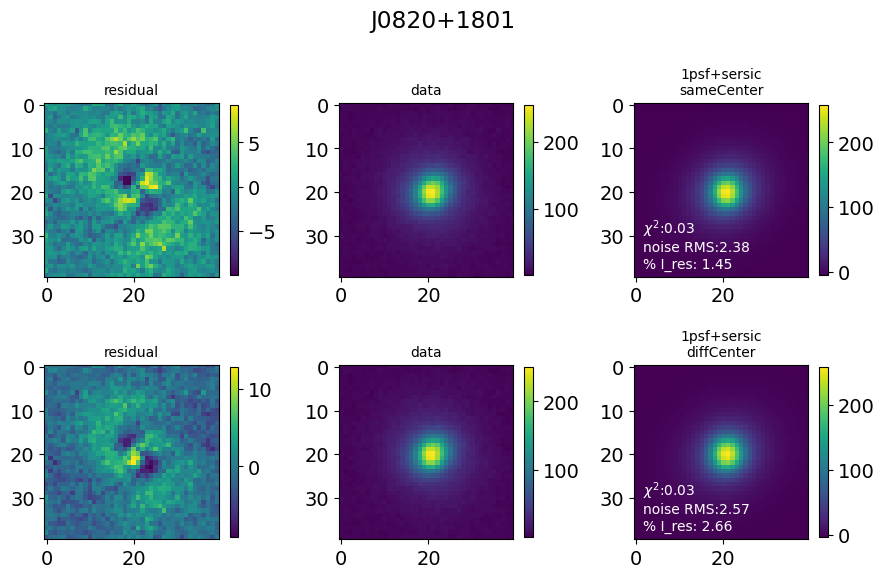

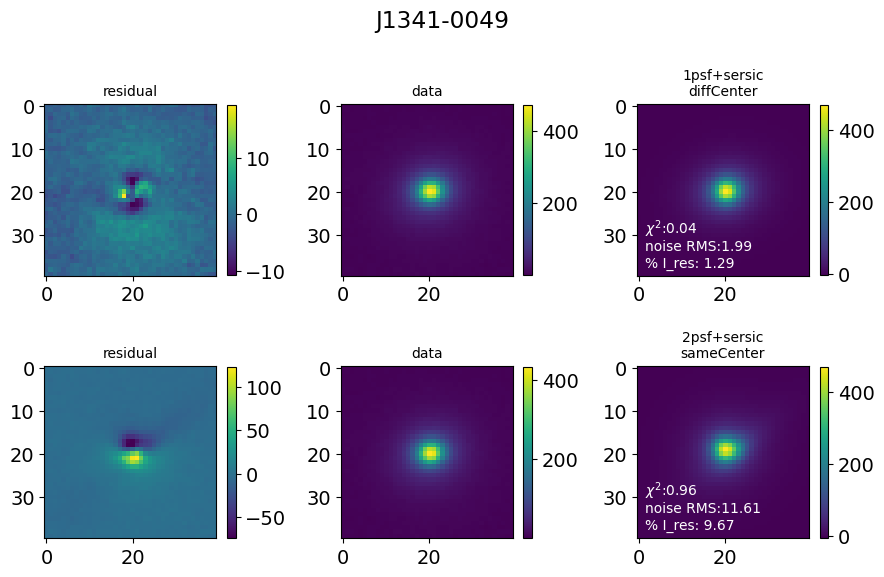

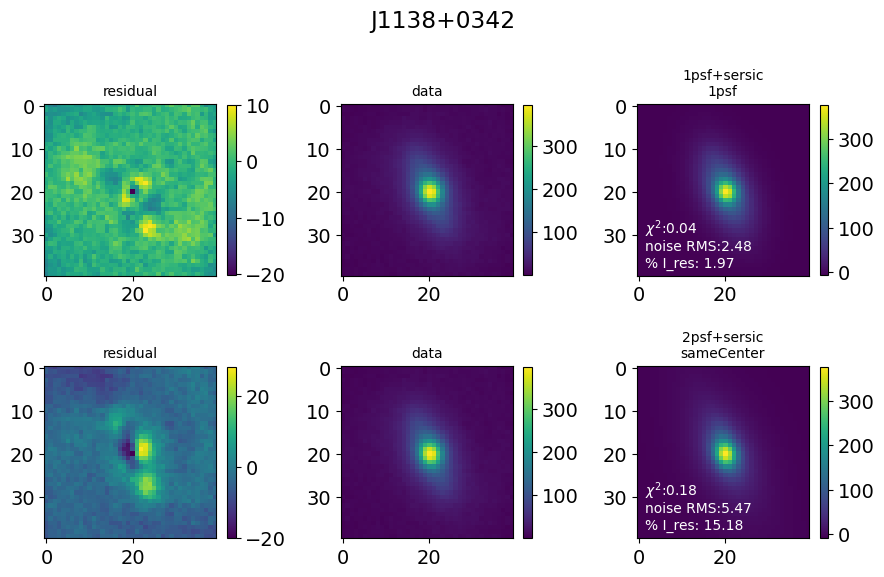

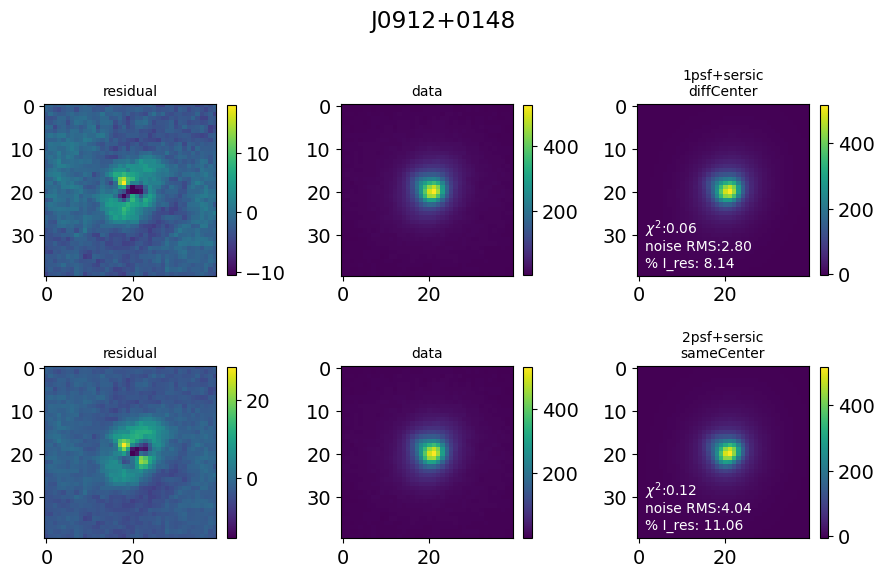

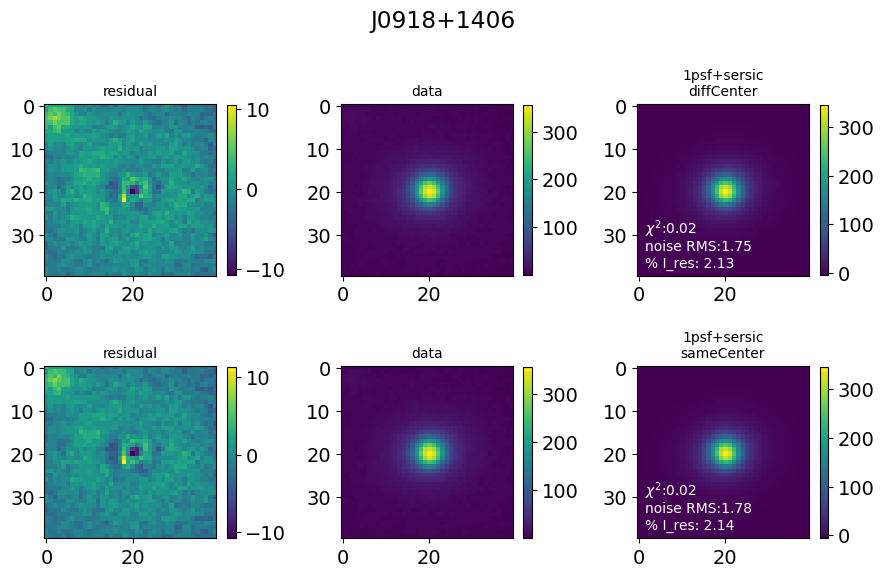

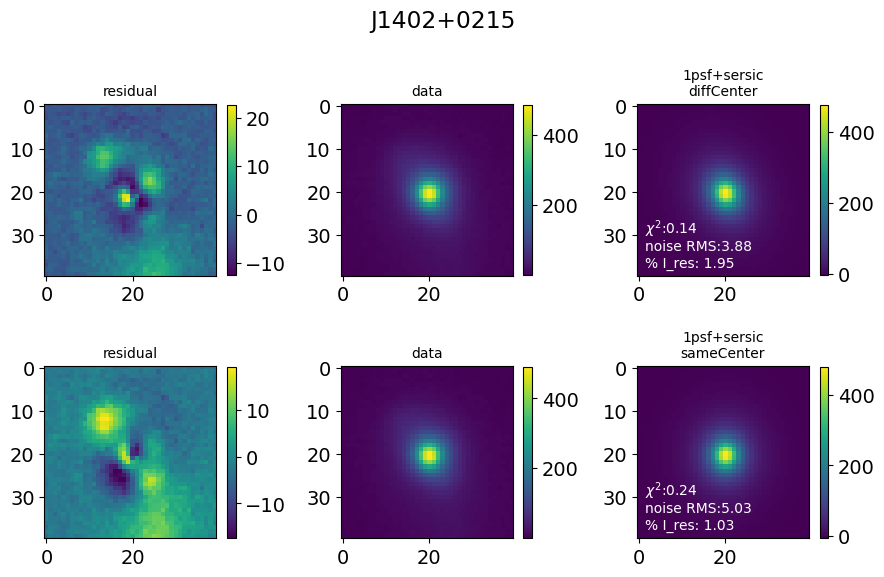

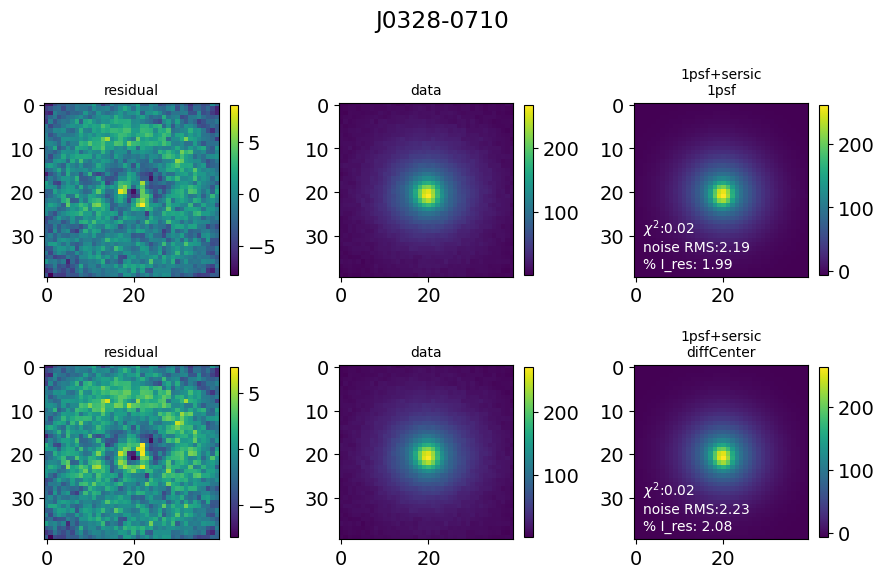

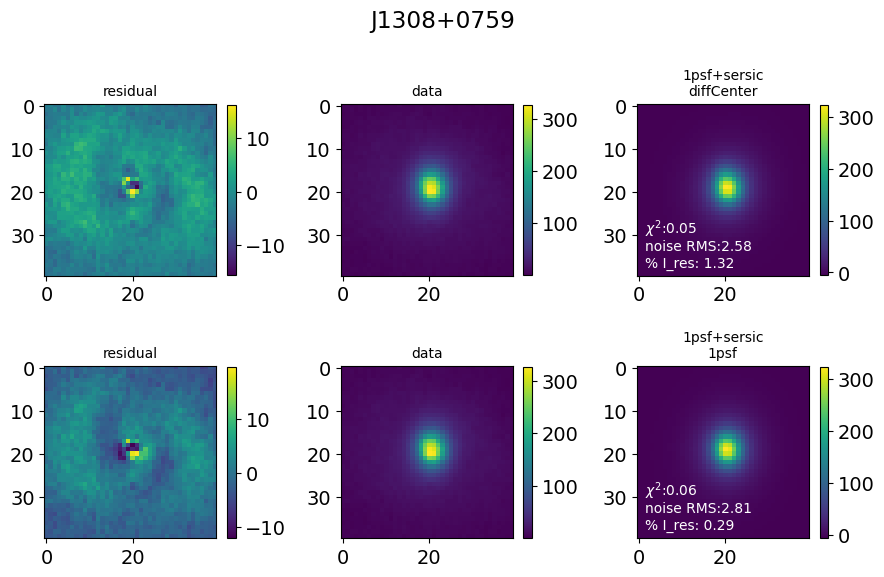

In [177]:
#-------plot 2 best for all agns and save best model to text 
fn = os.listdir("../fit/fit_pkls")
fn =[f for f in fn if f[0]=="J"]

pdf = PdfPages("../fit/fit_plots/all_models.pdf")
with PdfPages("../fit/fit_plots/all_models.pdf") as pdf:
    for i in range(len(fn)):
        with open("../fit/fit_pkls/"+fn[i], "rb") as f:
            d = pickle.load(f)
        oname = fn[i].split(".")[0]
        plot_fit_result(pdf,d,oname,plot2best=True)
        
        
"""with open("fit_summary.txt","w") as f_write:
    for i in range(len(fn)):
        oname = fn[i].split(".")[0]
        with open("../fit/fit_pkls/"+fn[i], "rb") as f:
            d = pickle.load(f)
        modelNum = len(d['fitResults'])
        fitStats = [d['fitResults'][i].fitStatReduced for i in range(modelNum)]
        best = np.argsort([d['fitResults'][i].fitStatReduced for i in range(n_models)])[0]
        bestname = list(d['modelNames'])[best]
        f_write.write(f'{oname} : {bestname}\n')"""